In [1]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa import ar_model

In [2]:
# statusデータ
status = pd.read_csv('../../../status.csv')

In [3]:
#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str) + '/' + status['hour'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'], format='%Y/%m/%d/%H', infer_datetime_format=True)
status.head()

,id,year,month,day,hour,station_id,bikes_available,predict,date
0,0,2013,9,1,0,0,11.0,0,2013-09-01 00:00:00
1,1,2013,9,1,1,0,11.0,0,2013-09-01 01:00:00
2,2,2013,9,1,2,0,11.0,0,2013-09-01 02:00:00
3,3,2013,9,1,3,0,11.0,0,2013-09-01 03:00:00
4,4,2013,9,1,4,0,11.0,0,2013-09-01 04:00:00


In [4]:
status

,id,year,month,day,hour,station_id,bikes_available,predict,date
0,0,2013,9,1,0,0,11.0,0,2013-09-01 00:00:00
1,1,2013,9,1,1,0,11.0,0,2013-09-01 01:00:00
2,2,2013,9,1,2,0,11.0,0,2013-09-01 02:00:00
3,3,2013,9,1,3,0,11.0,0,2013-09-01 03:00:00
4,4,2013,9,1,4,0,11.0,0,2013-09-01 04:00:00
...,...,...,...,...,...,...,...,...,...
1226395,1226395,2015,8,31,19,69,8.0,0,2015-08-31 19:00:00
1226396,1226396,2015,8,31,20,69,8.0,0,2015-08-31 20:00:00
1226397,1226397,2015,8,31,21,69,8.0,0,2015-08-31 21:00:00
1226398,1226398,2015,8,31,22,69,8.0,0,2015-08-31 22:00:00


In [5]:
status_v0 = status[status['station_id'] == 0] 
status_v0 = status_v0[status_v0['date'] >= '2013-10-01']
status_v0 = status_v0[status_v0['date'] < '2013-11-01']

In [6]:
status_v0

,id,year,month,day,hour,station_id,bikes_available,predict,date
720,720,2013,10,1,0,0,16.0,0,2013-10-01 00:00:00
721,721,2013,10,1,1,0,14.0,0,2013-10-01 01:00:00
722,722,2013,10,1,2,0,14.0,0,2013-10-01 02:00:00
723,723,2013,10,1,3,0,14.0,0,2013-10-01 03:00:00
724,724,2013,10,1,4,0,14.0,0,2013-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...
1459,1459,2013,10,31,19,0,19.0,0,2013-10-31 19:00:00
1460,1460,2013,10,31,20,0,18.0,0,2013-10-31 20:00:00
1461,1461,2013,10,31,21,0,18.0,0,2013-10-31 21:00:00
1462,1462,2013,10,31,22,0,18.0,0,2013-10-31 22:00:00


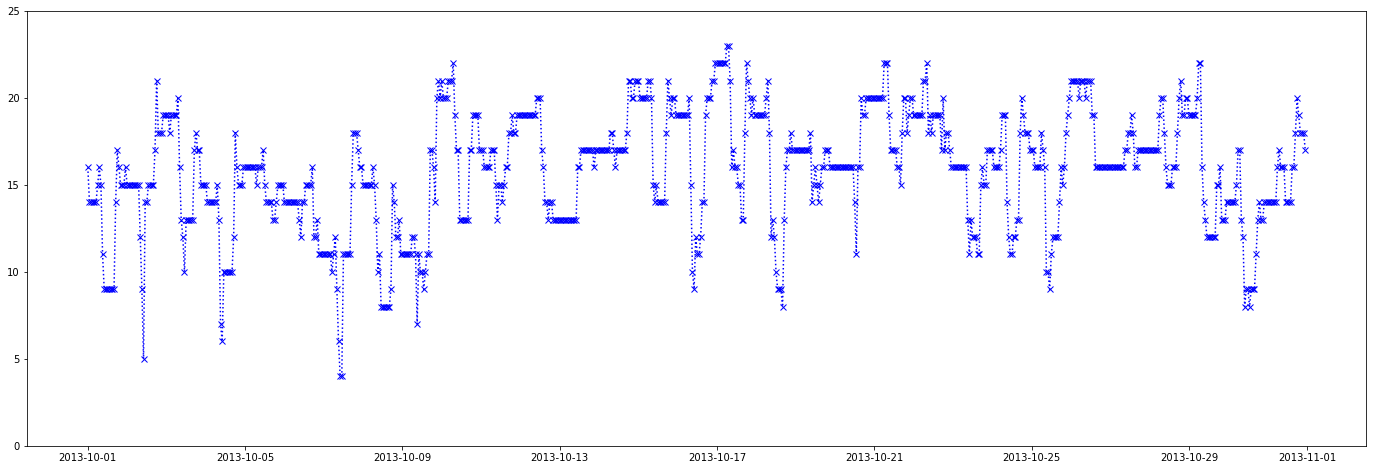

In [7]:
plt.figure(figsize=(24,8))
plt.ylim(0, 25)
plt.plot(status_v0['date'], status_v0['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')

In [8]:
status_v1 = status_v0.set_index('date')

In [9]:
status_v2 = status_v1['bikes_available']

In [10]:
status_test = status[status['station_id'] == 0] 
status_test = status_test[status_test['date'] >= '2013-10-01']
status_test = status_test[status_test['date'] < '2013-11-08']
status_test_v1 = status_test.set_index('date')
status_test_v2 = status_test_v1['bikes_available']

In [11]:
status_test_v2

date
2013-10-01 00:00:00    16.0
2013-10-01 01:00:00    14.0
2013-10-01 02:00:00    14.0
2013-10-01 03:00:00    14.0
2013-10-01 04:00:00    14.0
                       ... 
2013-11-07 19:00:00    18.0
2013-11-07 20:00:00    16.0
2013-11-07 21:00:00    16.0
2013-11-07 22:00:00    16.0
2013-11-07 23:00:00    16.0
Name: bikes_available, Length: 912, dtype: float64

In [12]:
status_test = status_test[status_test['date'] >= '2013-11-01']
status_test_predict = status_test.set_index('date')
status_test_predict = status_test_predict['bikes_available']

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#    rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=24).mean()
#    rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

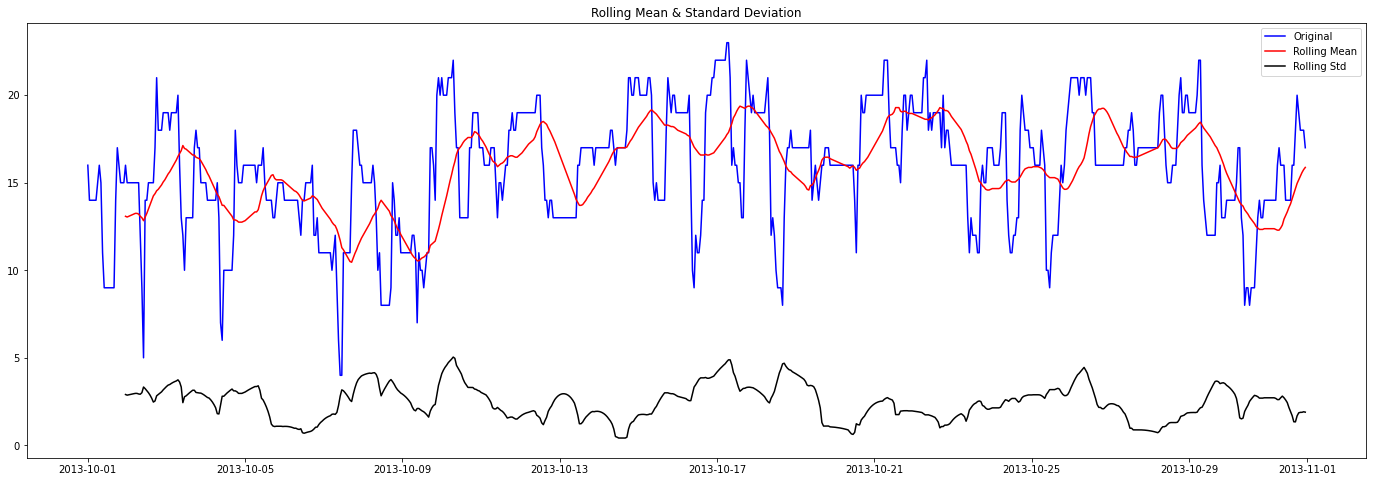

Results of Dickey-Fuller Test:
Test Statistic                  -3.442110
p-value                          0.009604
#Lags Used                      18.000000
Number of Observations Used    725.000000
Critical Value (1%)             -3.439402
Critical Value (5%)             -2.865535
Critical Value (10%)            -2.568897
dtype: float64


In [15]:
plt.figure(figsize=(24,8))
test_stationarity(status_v2)

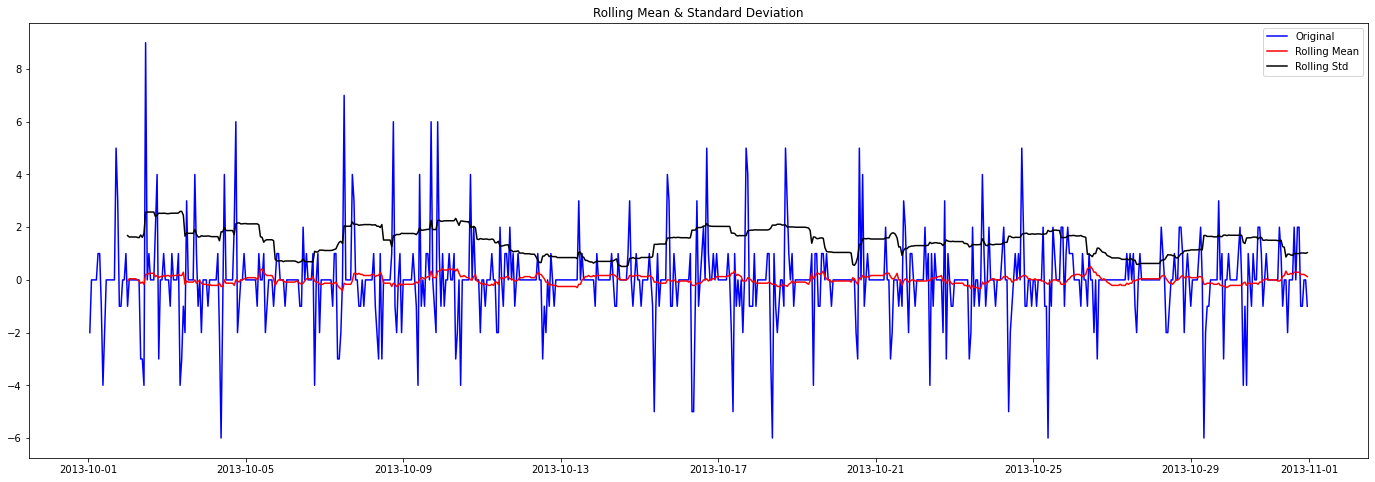

Results of Dickey-Fuller Test:
Test Statistic                -1.076623e+01
p-value                        2.448642e-19
#Lags Used                     2.000000e+01
Number of Observations Used    7.220000e+02
Critical Value (1%)           -3.439440e+00
Critical Value (5%)           -2.865551e+00
Critical Value (10%)          -2.568906e+00
dtype: float64


In [16]:
status_v2_diff = status_v2.diff()
plt.figure(figsize=(24,8))
test_stationarity(status_v2_diff.dropna())

In [17]:
status_v2.isnull().sum()

0

In [18]:
status_v2_diff.isnull().sum()

1

In [19]:
status_v2_diff

date
2013-10-01 00:00:00    NaN
2013-10-01 01:00:00   -2.0
2013-10-01 02:00:00    0.0
2013-10-01 03:00:00    0.0
2013-10-01 04:00:00    0.0
                      ... 
2013-10-31 19:00:00   -1.0
2013-10-31 20:00:00   -1.0
2013-10-31 21:00:00    0.0
2013-10-31 22:00:00    0.0
2013-10-31 23:00:00   -1.0
Name: bikes_available, Length: 744, dtype: float64

In [20]:
status_v2_diff[0]=0
status_v2_diff

date
2013-10-01 00:00:00    0.0
2013-10-01 01:00:00   -2.0
2013-10-01 02:00:00    0.0
2013-10-01 03:00:00    0.0
2013-10-01 04:00:00    0.0
                      ... 
2013-10-31 19:00:00   -1.0
2013-10-31 20:00:00   -1.0
2013-10-31 21:00:00    0.0
2013-10-31 22:00:00    0.0
2013-10-31 23:00:00   -1.0
Name: bikes_available, Length: 744, dtype: float64

In [21]:
status_v2_diff.isnull().sum()

0

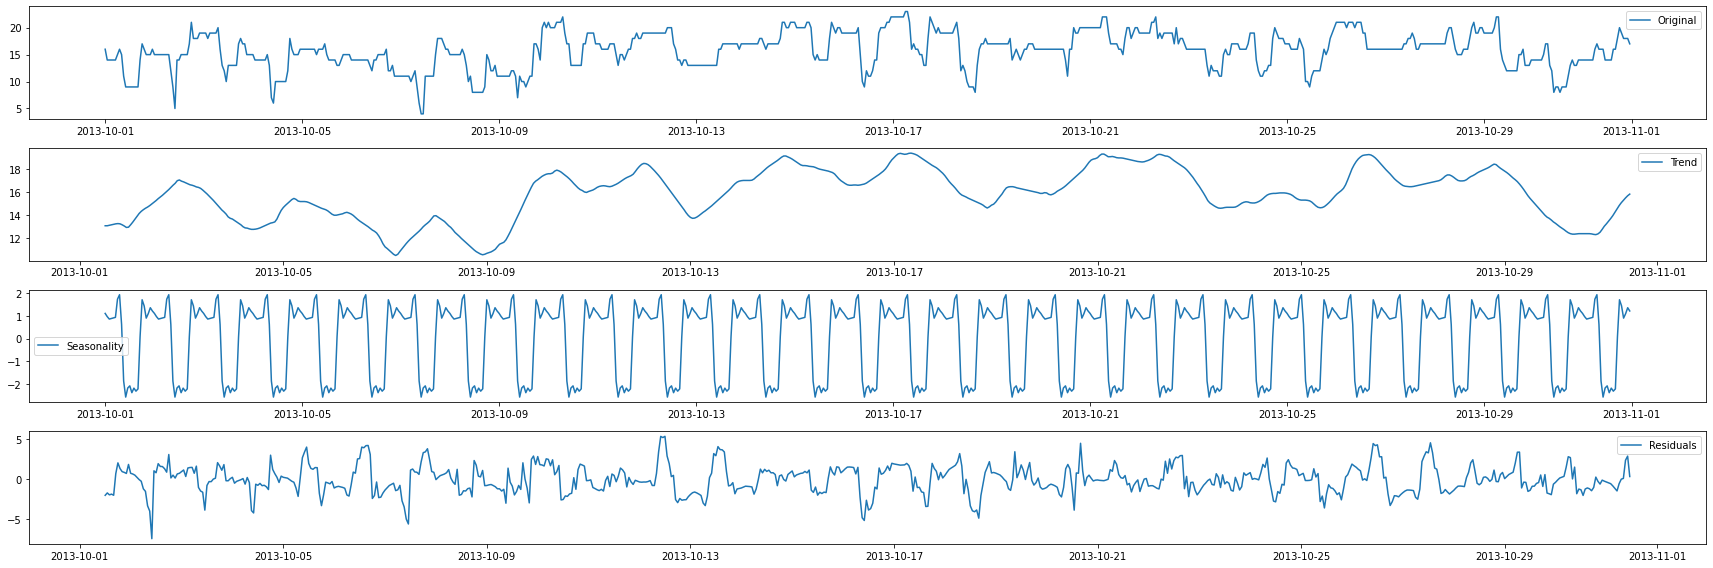

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(status_v2)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(24,8))
plt.subplot(411)
plt.plot(status_v2, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

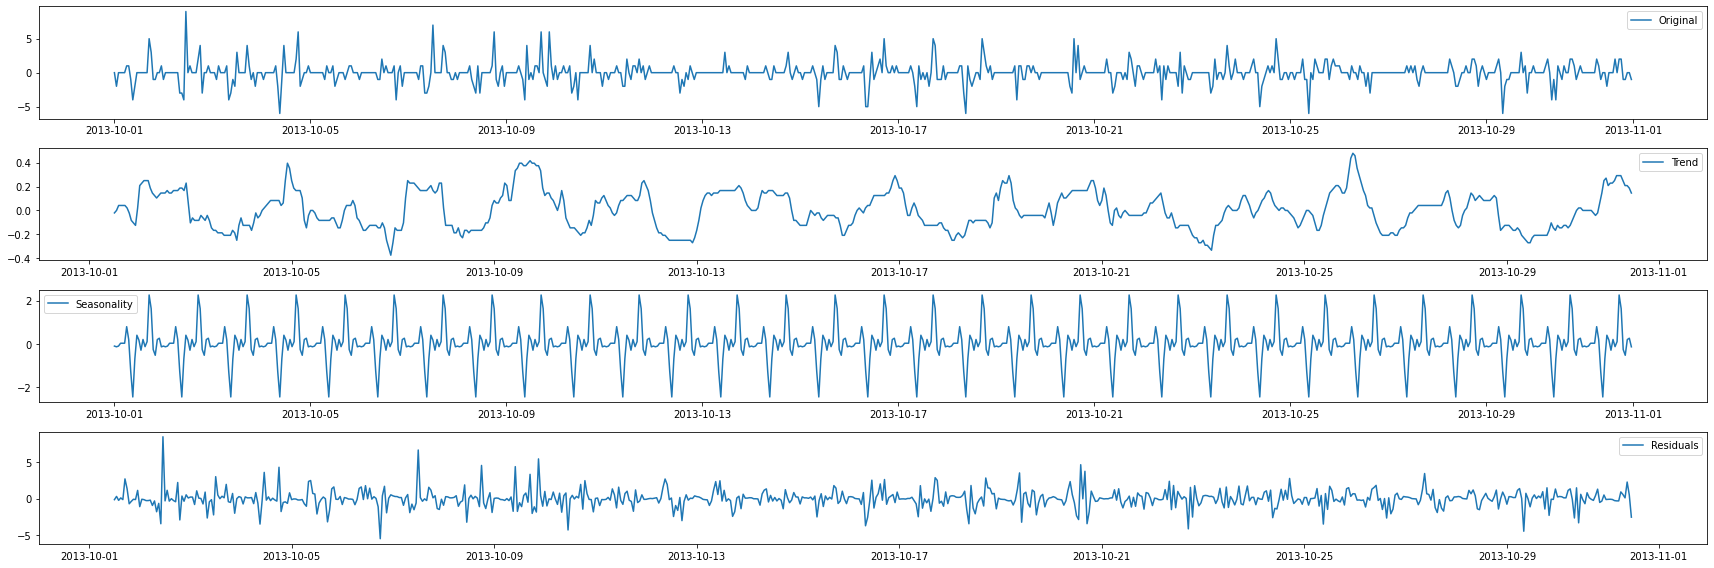

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(status_v2_diff)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(24,8))
plt.subplot(411)
plt.plot(status_v2_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [24]:
ctt = stattools.adfuller(status_v2, regression="ctt")
ct = stattools.adfuller(status_v2, regression="ct")
c = stattools.adfuller(status_v2, regression="c")
nc = stattools.adfuller(status_v2, regression="nc")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-4.01569853810298, 0.030119251801170813, 18, 725, {'1%': -4.3871827462629875, '5%': -3.8405598656843662, '10%': -3.558317960842019}, 2540.83661839875)
ct:
(-3.6025297545706847, 0.02963296082764329, 18, 725, {'1%': -3.971311470708926, '5%': -3.4165630341685183, '10%': -3.130623870856534}, 2541.6577420317526)
c:
(-3.4421104557694915, 0.009604403735110092, 18, 725, {'1%': -3.4394018678958544, '5%': -2.865534780932388, '10%': -2.5688972751486325}, 2540.6637357677264)
nc:
(-0.31187081822248214, 0.5714678914549502, 18, 725, {'1%': -2.5688307624256836, '5%': -1.9413768027277871, '10%': -1.6164587519908153}, 2551.0237445090092)


In [25]:
ctt = stattools.adfuller(status_v2_diff, regression="ctt")
ct = stattools.adfuller(status_v2_diff, regression="ct")
c = stattools.adfuller(status_v2_diff, regression="c")
nc = stattools.adfuller(status_v2_diff, regression="nc")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-10.768182484658462, 7.647967101708562e-17, 20, 723, {'1%': -4.387227346099118, '5%': -3.840582533227848, '10%': -3.558331981294508}, 2551.534682592489)
ct:
(-10.775628622010629, 6.026661617609998e-17, 20, 723, {'1%': -3.9713463155540447, '5%': -3.416579882057343, '10%': -3.130633778122807}, 2549.539561602955)
c:
(-10.779953614138073, 2.268546659939596e-19, 20, 723, {'1%': -3.4394269973845657, '5%': -2.8655458544300387, '10%': -2.568903174551249}, 2547.612731313774)
nc:
(-10.785024857881645, 2.0271762205951756e-19, 20, 723, {'1%': -2.5688393313935136, '5%': -1.9413778623620674, '10%': -1.6164577666408322}, 2545.66264050401)


In [26]:
import statsmodels.api as sm # version 0.8.0以上

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [28]:
p, d, q, sp, sd, sq = 4, 1, 0, 0, 0, 0
seasonal = 0

# AR(p=4,d=1,q=0; P=0,D=0,Q=0,s=0)モデルの当てはめ
result_ar = SARIMAX(
    status_v2, order=(p,d,q), 
    seasonal_order=(sp,sd,sq,seasonal), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()
# 結果確認
print(result_ar.summary())

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:        bikes_available   No. Observations:                  744
Model:               SARIMAX(4, 1, 0)   Log Likelihood               -1350.569
Date:                Thu, 16 Dec 2021   AIC                           2711.139
Time:                        22:34:28   BIC                           2734.165
Sample:                    10-01-2013   HQIC                          2720.018
                         - 10-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0945      0.029      3.280      0.001       0.038       0.151
ar.L2         -0.0621      0.036     -1.729      0.084      -0.133       0.008
ar.L3         -0.0914      0.041     -2.231      0.0

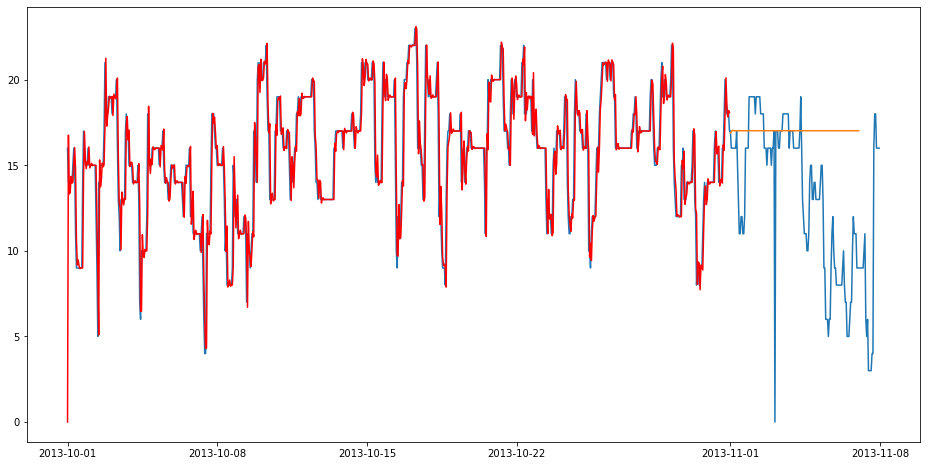

In [29]:
# 将来予測
plt.figure(figsize=(16,8))
plt.plot(status_test_v2, label="observation")
plt.plot(result_ar.fittedvalues, color='red')
predict_ar = result_ar.predict('2013-11-01', '2013-11-07')
plt.plot(predict_ar) # 予測データをプロット

In [30]:
p, d, q, sp, sd, sq = 0, 1, 5, 0, 0, 0
seasonal = 0

# MAモデルの当てはめいろいろ
result_ma = SARIMAX(
    status_v2, order=(p,d,q), 
    seasonal_order=(sp,sd,sq,seasonal), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()
# 結果確認
print(result_ma.summary())

                               SARIMAX Results                                
Dep. Variable:        bikes_available   No. Observations:                  744
Model:               SARIMAX(0, 1, 5)   Log Likelihood               -1346.182
Date:                Thu, 16 Dec 2021   AIC                           2704.364
Time:                        22:34:28   BIC                           2731.979
Sample:                    10-01-2013   HQIC                          2715.013
                         - 10-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0856      0.029      2.963      0.003       0.029       0.142
ma.L2         -0.0628      0.036     -1.756      0.079      -0.133       0.007
ma.L3         -0.1404      0.040     -3.503      0.0

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


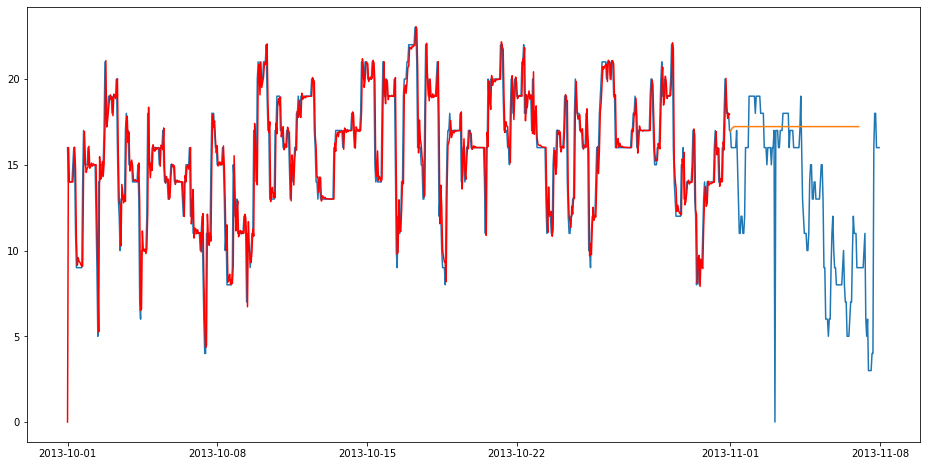

In [31]:
# 将来予測
plt.figure(figsize=(16,8))
plt.plot(status_test_v2, label="observation")
plt.plot(result_ma.fittedvalues, color='red')
predict_ma = result_ma.predict('2013-11-01', '2013-11-07')
plt.plot(predict_ma) # 予測データをプロット

In [32]:
p, d, q, sp, sd, sq = 4, 1, 5, 0, 0, 0
seasonal = 0

# ARIMAモデルの当てはめいろいろ
result_arima = SARIMAX(
    status_v2, order=(p,d,q), 
    seasonal_order=(sp,sd,sq,seasonal), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()
# 結果確認
print(result_arima.summary())

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:        bikes_available   No. Observations:                  744
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -1312.326
Date:                Thu, 16 Dec 2021   AIC                           2644.652
Time:                        22:34:30   BIC                           2690.678
Sample:                    10-01-2013   HQIC                          2662.402
                         - 10-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6916      0.273      6.189      0.000       1.156       2.227
ar.L2         -0.8014      0.631     -1.270      0.204      -2.038       0.435
ar.L3         -0.3152      0.575     -0.548      0.5

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


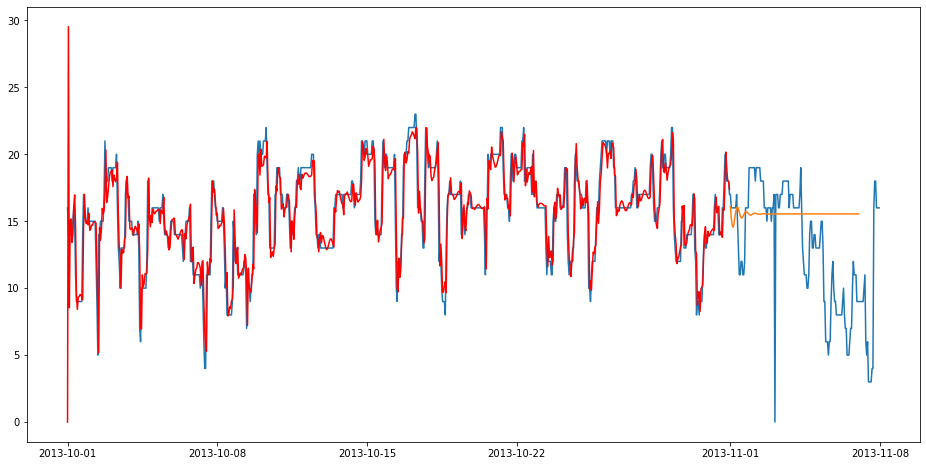

In [33]:
# 将来予測
plt.figure(figsize=(16,8))
plt.plot(status_test_v2, label="observation")
plt.plot(result_arima.fittedvalues, color='red')
predict_arima = result_arima.predict('2013-11-01', '2013-11-07')
plt.plot(predict_arima) # 予測データをプロット

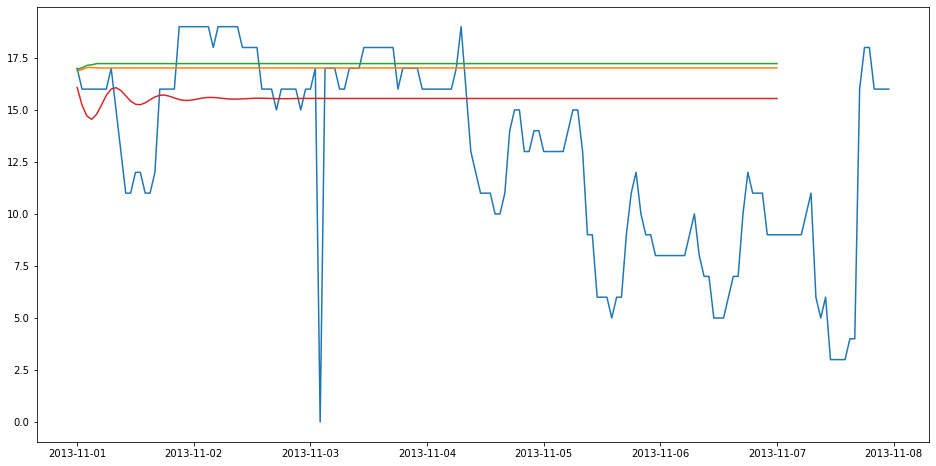

In [34]:
#predict = result.predict('2013-11-01', '2013-11-07')
plt.figure(figsize=(16,8))
plt.plot(status_test_predict, label="observation")
plt.plot(predict_ar)
plt.plot(predict_ma)
plt.plot(predict_arima)
# 予測データをプロット

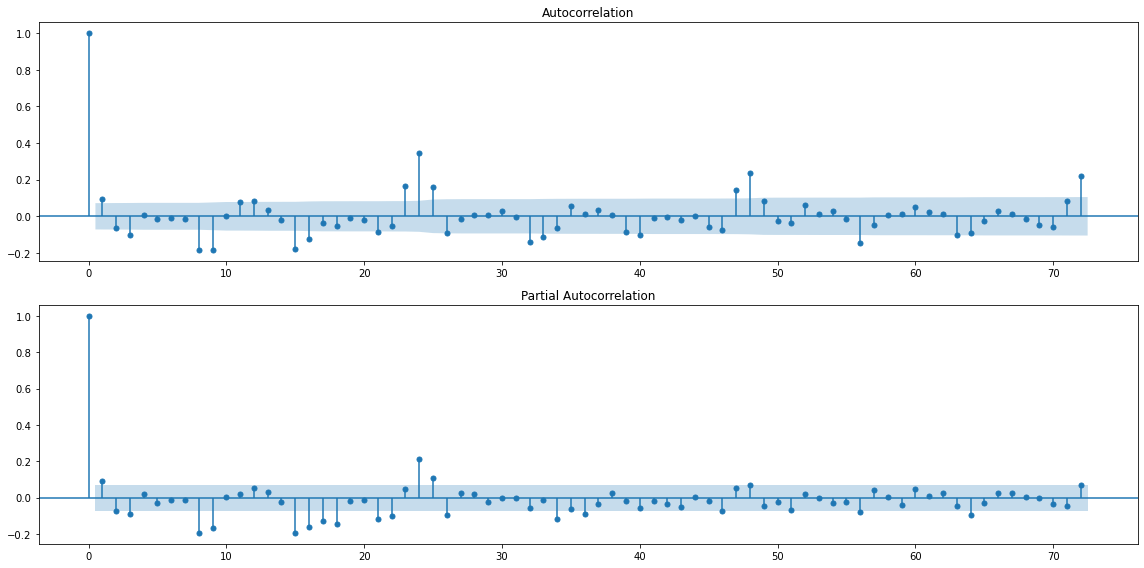

In [35]:
# 差分系列のコレログラム
fig = plt.figure(figsize=(16, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(status_v2_diff, lags=72, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(status_v2_diff, lags=72, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [36]:
import itertools
 
# 各パラメータの範囲を決める
p = q = range(0, 8)
d = range(1,2)
sp = sd = sq = range(0, 2)
 
# p, d, q　の組み合わせを列挙するリストを作成
pdq = list(itertools.product(p, d, q))
 
# P, D, Q　の組み合わせを列挙するリストを作成すると同時に、後ろに　s = 12　を決め打ちでつけている。
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(sp, sd, sq))]

In [37]:
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (1, 1, 7),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 1, 6),
 (2, 1, 7),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (3, 1, 6),
 (3, 1, 7),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (4, 1, 6),
 (4, 1, 7),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5),
 (5, 1, 6),
 (5, 1, 7),
 (6, 1, 0),
 (6, 1, 1),
 (6, 1, 2),
 (6, 1, 3),
 (6, 1, 4),
 (6, 1, 5),
 (6, 1, 6),
 (6, 1, 7),
 (7, 1, 0),
 (7, 1, 1),
 (7, 1, 2),
 (7, 1, 3),
 (7, 1, 4),
 (7, 1, 5),
 (7, 1, 6),
 (7, 1, 7)]

In [38]:
#best_result = [0, 0, 10000000]
#for param in pdq:
#    for param_seasonal in seasonal_pdq:
#        try:
#            mod = SARIMAX(status_v2,
#                          order = param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=True,
#                          enforce_invertibility=True)
# 
#            results = mod.fit()
#             
#            print('order{}, s_order{} - AIC: {}'.format(param, param_seasonal, results.aic))
# 
#            if results.aic < best_result[2]:
#                best_result = [param, param_seasonal, results.aic]
#        except:
#            continue
#             
#print('\AICが最も良いモデル:', best_result)

In [39]:
p, d, q, sp, sd, sq = 4, 1, 5, 0, 1, 0
seasonal = 24

# SARIMAモデルの当てはめいろいろ
result_sarima = SARIMAX(
    status_v2, order=(p,d,q), 
    seasonal_order=(sp,sd,sq,seasonal), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()
# 結果確認
print(result_sarima.summary())

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                     bikes_available   No. Observations:                  744
Model:             SARIMAX(4, 1, 5)x(0, 1, [], 24)   Log Likelihood               -1388.798
Date:                             Thu, 16 Dec 2021   AIC                           2797.596
Time:                                     22:34:39   BIC                           2843.291
Sample:                                 10-01-2013   HQIC                          2815.245
                                      - 10-31-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0031      0.588     -0.005      0.996      -1.157       1.150
ar.L2         -0.5753      

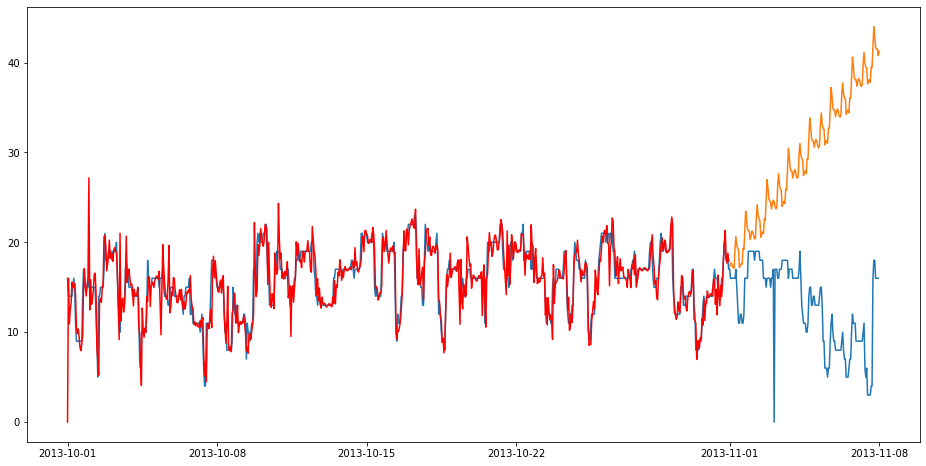

In [40]:
# 将来予測
plt.figure(figsize=(16,8))
plt.plot(status_test_v2, label="observation")
plt.plot(result_sarima.fittedvalues, color='red')
predict_sarima = result_sarima.predict('2013-11-01', '2013-11-08')
plt.plot(predict_sarima) # 予測データをプロット

In [41]:
p, d, q, sp, sd, sq = 4, 1, 5, 1, 1, 1
seasonal = 24

# SARIMAモデルの当てはめいろいろ
result_sarima_1 = SARIMAX(
    status_v2, order=(p,d,q), 
    seasonal_order=(sp,sd,sq,seasonal), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()
# 結果確認
print(result_sarima_1.summary())

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                      bikes_available   No. Observations:                  744
Model:             SARIMAX(4, 1, 5)x(1, 1, [1], 24)   Log Likelihood               -1178.356
Date:                              Thu, 16 Dec 2021   AIC                           2380.712
Time:                                      22:35:07   BIC                           2435.135
Sample:                                  10-01-2013   HQIC                          2401.765
                                       - 10-31-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3641      0.138     -2.642      0.008      -0.634      -0.094
ar.L2         -0.83

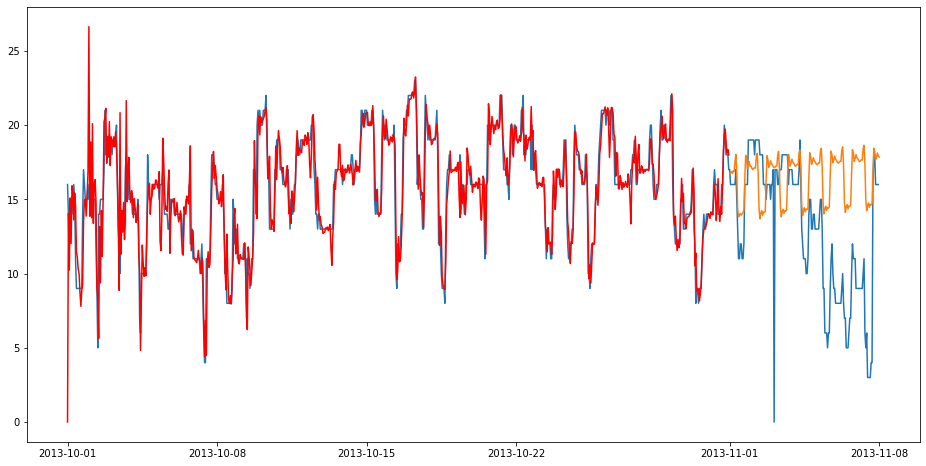

In [42]:
# 将来予測
plt.figure(figsize=(16,8))
plt.plot(status_test_v2, label="observation")
plt.plot(result_sarima_1.fittedvalues, color='red')
predict_sarima_1 = result_sarima_1.predict('2013-11-01', '2013-11-08')
plt.plot(predict_sarima_1) # 予測データをプロット

In [43]:
p, d, q, sp, sd, sq = 4, 1, 5, 0, 0, 1
seasonal = 24

# SARIMAモデルの当てはめいろいろ
result_sarima_2 = SARIMAX(
    status_v2, order=(p,d,q), 
    seasonal_order=(sp,sd,sq,seasonal), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()
# 結果確認
print(result_sarima_2.summary())

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                      bikes_available   No. Observations:                  744
Model:             SARIMAX(4, 1, 5)x(0, 0, [1], 24)   Log Likelihood               -1249.214
Date:                              Thu, 16 Dec 2021   AIC                           2520.428
Time:                                      22:35:15   BIC                           2570.692
Sample:                                  10-01-2013   HQIC                          2539.842
                                       - 10-31-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4907      0.113     13.167      0.000       1.269       1.713
ar.L2         -0.45

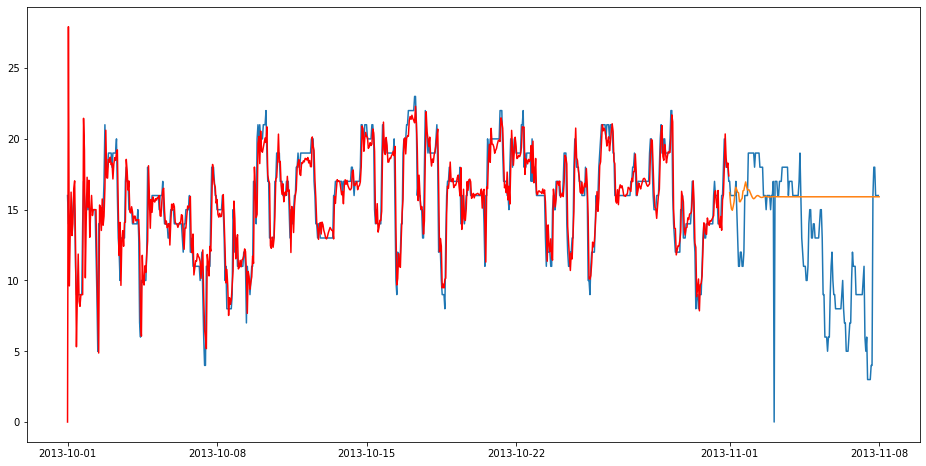

In [44]:
# 将来予測
plt.figure(figsize=(16,8))
plt.plot(status_test_v2, label="observation")
plt.plot(result_sarima_2.fittedvalues, color='red')
predict_sarima_2 = result_sarima_2.predict('2013-11-01', '2013-11-08')
plt.plot(predict_sarima_2) # 予測データをプロット

In [45]:
p, d, q, sp, sd, sq = 4, 1, 5, 1, 0, 0
seasonal = 24

# SARIMAモデルの当てはめいろいろ
result_sarima_3 = SARIMAX(
    status_v2, order=(p,d,q), 
    seasonal_order=(sp,sd,sq,seasonal), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()
# 結果確認
print(result_sarima_3.summary())

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                     bikes_available   No. Observations:                  744
Model:             SARIMAX(4, 1, 5)x(1, 0, [], 24)   Log Likelihood               -1235.952
Date:                             Thu, 16 Dec 2021   AIC                           2493.905
Time:                                     22:35:23   BIC                           2544.200
Sample:                                 10-01-2013   HQIC                          2513.328
                                      - 10-31-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8832      0.287      6.557      0.000       1.320       2.446
ar.L2         -1.3814      

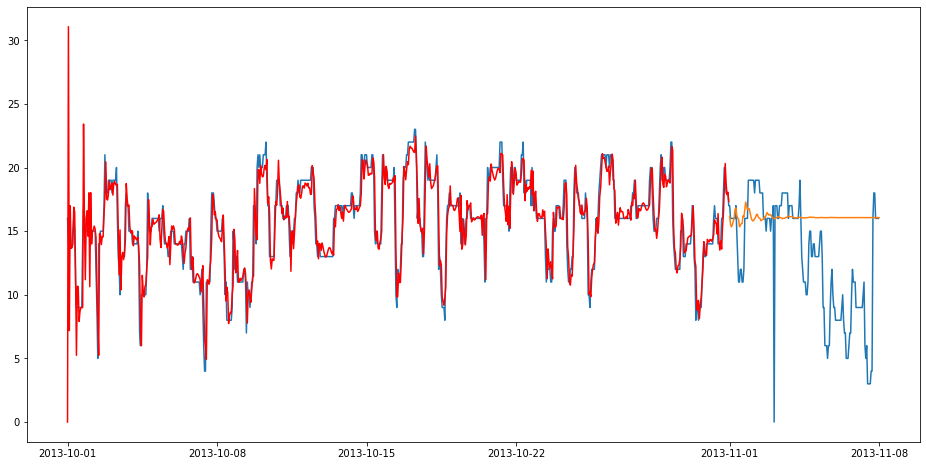

In [46]:
# 将来予測
plt.figure(figsize=(16,8))
plt.plot(status_test_v2, label="observation")
plt.plot(result_sarima_3.fittedvalues, color='red')
predict_sarima_3 = result_sarima_3.predict('2013-11-01', '2013-11-08')
plt.plot(predict_sarima_3) # 予測データをプロット

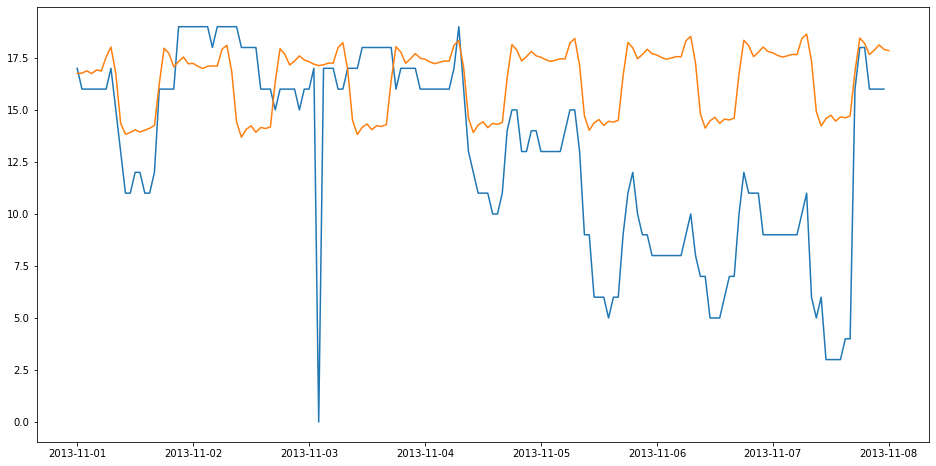

In [47]:
plt.figure(figsize=(16,8))
plt.plot(status_test_predict, label="observation")
#plt.plot(predict_arima) # 予測データをプロット
#plt.plot(predict_sarima)#010
plt.plot(predict_sarima_1)#111
#plt.plot(predict_sarima_2)#001
#plt.plot(predict_sarima_3)#100

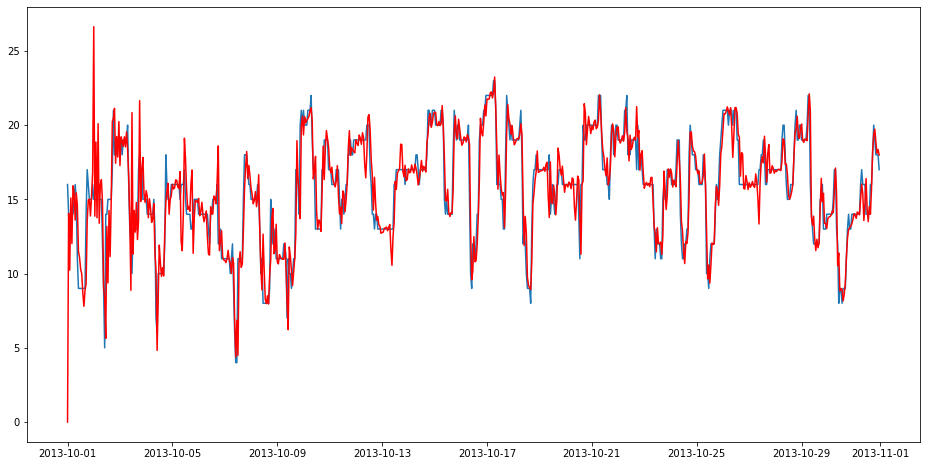

In [48]:
# もっともよかったsarimaの学習グラフ
plt.figure(figsize=(16,8))
plt.plot(status_v2, label="observation")
plt.plot(result_sarima_1.fittedvalues, color='red')

In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
#trainデータのrmse
mean_squared_error(result_sarima_1.fittedvalues, status_v2, squared=False)

1.6504571981947849

In [51]:
len(predict_sarima_1)

169

In [52]:
predict_sarima_1

2013-11-01 00:00:00    16.751203
2013-11-01 01:00:00    16.769001
2013-11-01 02:00:00    16.879888
2013-11-01 03:00:00    16.747203
2013-11-01 04:00:00    16.919028
                         ...    
2013-11-07 20:00:00    17.663209
2013-11-07 21:00:00    17.874381
2013-11-07 22:00:00    18.124178
2013-11-07 23:00:00    17.911173
2013-11-08 00:00:00    17.847853
Freq: H, Name: predicted_mean, Length: 169, dtype: float64

In [53]:
predict_sarima_1[:-1]

2013-11-01 00:00:00    16.751203
2013-11-01 01:00:00    16.769001
2013-11-01 02:00:00    16.879888
2013-11-01 03:00:00    16.747203
2013-11-01 04:00:00    16.919028
                         ...    
2013-11-07 19:00:00    18.192569
2013-11-07 20:00:00    17.663209
2013-11-07 21:00:00    17.874381
2013-11-07 22:00:00    18.124178
2013-11-07 23:00:00    17.911173
Freq: H, Name: predicted_mean, Length: 168, dtype: float64

In [54]:
len(status_test_predict)

168

In [55]:
status_test_predict

date
2013-11-01 00:00:00    17.0
2013-11-01 01:00:00    16.0
2013-11-01 02:00:00    16.0
2013-11-01 03:00:00    16.0
2013-11-01 04:00:00    16.0
                       ... 
2013-11-07 19:00:00    18.0
2013-11-07 20:00:00    16.0
2013-11-07 21:00:00    16.0
2013-11-07 22:00:00    16.0
2013-11-07 23:00:00    16.0
Name: bikes_available, Length: 168, dtype: float64

In [56]:
#testデータのrmse
mean_squared_error(predict_sarima_1[:-1], status_test_predict, squared=False)

5.631407999443855

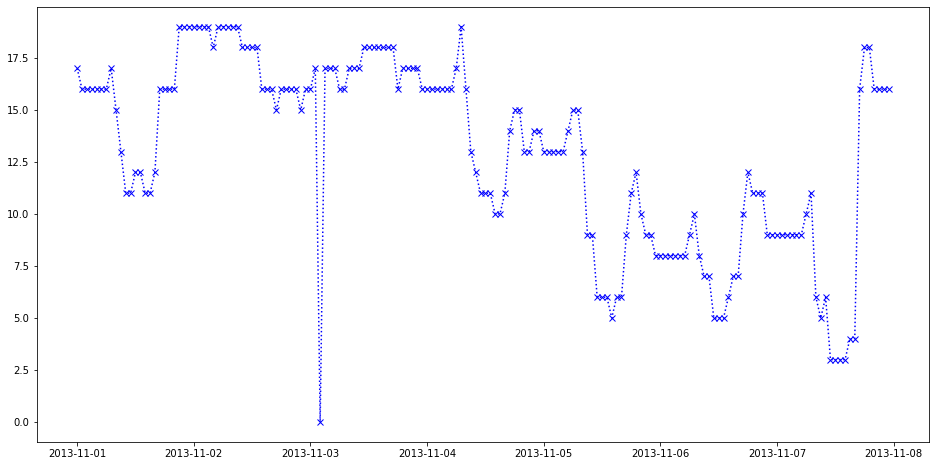

In [57]:
plt.figure(figsize=(16,8))
plt.plot(status_test_predict, color = 'blue', marker = 'x', linestyle = ':')
#plt.plot(predict_arima) # 予測データをプロット
#plt.plot(predict_sarima)#010
#plt.plot(predict_sarima_1)#111
#plt.plot(predict_sarima_2)#001
#plt.plot(predict_sarima_3)#100

In [58]:
#ここから下は機械学習

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

import math
from statistics import mean
from datetime import timedelta
from sklearn.metrics import mean_squared_error


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

from datetime import date
import datetime
import holidays

In [60]:
trip = pd.read_csv('../../../trip.csv')
station = pd.read_csv('../../../station.csv')
weather = pd.read_csv('../../../weather.csv')

In [61]:
#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'])

#statusにstationのcityをマージ
status = pd.merge(status, station[['station_id', 'city']], how = 'left')

weather['date'] = pd.to_datetime(weather['date'])
#weatherのmean_wind_speedをマージ
status = pd.merge(status, weather[['date', 'mean_wind_speed']], how = 'left')

#weatherのprecipitationをマージ
status = pd.merge(status, weather[['date', 'precipitation']], how = 'left')

In [62]:
#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#dateから曜日情報を取得
status["weekday"] = status["date"].apply(get_weekday_jp)
status.head(10)

,id,year,month,day,hour,station_id,bikes_available,predict,date,city,mean_wind_speed,precipitation,weekday
0,0,2013,9,1,0,0,11.0,0,2013-09-01,city1,4,0.0,日曜日
1,1,2013,9,1,1,0,11.0,0,2013-09-01,city1,4,0.0,日曜日
2,2,2013,9,1,2,0,11.0,0,2013-09-01,city1,4,0.0,日曜日
3,3,2013,9,1,3,0,11.0,0,2013-09-01,city1,4,0.0,日曜日
4,4,2013,9,1,4,0,11.0,0,2013-09-01,city1,4,0.0,日曜日
5,5,2013,9,1,5,0,11.0,0,2013-09-01,city1,4,0.0,日曜日
6,6,2013,9,1,6,0,11.0,0,2013-09-01,city1,4,0.0,日曜日
7,7,2013,9,1,7,0,11.0,0,2013-09-01,city1,4,0.0,日曜日
8,8,2013,9,1,8,0,11.0,0,2013-09-01,city1,4,0.0,日曜日
9,9,2013,9,1,9,0,11.0,0,2013-09-01,city1,4,0.0,日曜日


In [63]:
week_df = pd.get_dummies(status['weekday'])
#weatherのprecipitationをマージ
status['Saturday'] = week_df['土曜日']
status['Sunday'] = week_df['日曜日']
status['Monday'] = week_df['月曜日']
status['Tuesday'] = week_df['火曜日']
status['Wednesday'] = week_df['水曜日']
status['Thursday'] = week_df['木曜日']
status['Friday'] = week_df['金曜日']

In [64]:
#city列をcategorical encoderを用いて数値化
cols = ['city']

#encoder = ce.CountEncoder()
#temp_ = encoder.fit_transform(status[cols]).add_prefix("CE_")

# OneHotEncodeしたい列を指定
encoder = ce.OneHotEncoder(cols=cols, handle_unknown='impute')
temp_ = encoder.fit_transform(status[cols]).add_prefix("CE_")

status = pd.concat([status, temp_], axis=1)

In [65]:
#statusにstationのdock_countをマージ
status = pd.merge(status, station[['station_id', 'dock_count']], how = 'left')
#statusにstationのinstallation_dateをマージ
status = pd.merge(status, station[['station_id', 'installation_date']], how = 'left')

In [66]:
#statusのdate列の曜日を数値化
status['week_num'] = status['date'].dt.weekday
status.head()

,id,year,month,day,hour,station_id,bikes_available,predict,date,city,...,Thursday,Friday,CE_city_1,CE_city_2,CE_city_3,CE_city_4,CE_city_5,dock_count,installation_date,week_num
0,0,2013,9,1,0,0,11.0,0,2013-09-01,city1,...,0,0,1,0,0,0,0,27,8/6/2013,6
1,1,2013,9,1,1,0,11.0,0,2013-09-01,city1,...,0,0,1,0,0,0,0,27,8/6/2013,6
2,2,2013,9,1,2,0,11.0,0,2013-09-01,city1,...,0,0,1,0,0,0,0,27,8/6/2013,6
3,3,2013,9,1,3,0,11.0,0,2013-09-01,city1,...,0,0,1,0,0,0,0,27,8/6/2013,6
4,4,2013,9,1,4,0,11.0,0,2013-09-01,city1,...,0,0,1,0,0,0,0,27,8/6/2013,6


In [67]:
status.dtypes

id                            int64
year                          int64
month                         int64
day                           int64
hour                          int64
station_id                    int64
bikes_available             float64
predict                       int64
date                 datetime64[ns]
city                         object
mean_wind_speed               int64
precipitation               float64
weekday                      object
Saturday                      uint8
Sunday                        uint8
Monday                        uint8
Tuesday                       uint8
Wednesday                     uint8
Thursday                      uint8
Friday                        uint8
CE_city_1                     int64
CE_city_2                     int64
CE_city_3                     int64
CE_city_4                     int64
CE_city_5                     int64
dock_count                    int64
installation_date            object
week_num                    

In [68]:
#同じステーション、同じ日において、0時時点の台数を特徴量に追加
#station_id, dateでグルーピングしたときの一番初めの値を取得
t = status.groupby(['station_id', 'date']).first()['bikes_available'].reset_index()
#24回リピートすることでデータのサイズを合わせる
t = pd.DataFrame(np.repeat(t.values, 24, axis=0))
t.columns = ['station_id', 'date', 'bikes_available_at0']
t.head(10)
status['bikes_available_at0'] = t['bikes_available_at0']

In [69]:
status['bikes_available_at0'] = status['bikes_available_at0'].astype(float)

In [70]:
#2014/09/01以前をtrain、以後をtestに分割(testはpredict = 1のものに絞る)
train_week = status[status['date'] >= '2013-10-01']
train_week = train_week[train_week['date'] < '2013-11-01']
train_week = train_week[train_week['station_id'] == 0] 
train_week

,id,year,month,day,hour,station_id,bikes_available,predict,date,city,...,Friday,CE_city_1,CE_city_2,CE_city_3,CE_city_4,CE_city_5,dock_count,installation_date,week_num,bikes_available_at0
720,720,2013,10,1,0,0,16.0,0,2013-10-01,city1,...,0,1,0,0,0,0,27,8/6/2013,1,16.0
721,721,2013,10,1,1,0,14.0,0,2013-10-01,city1,...,0,1,0,0,0,0,27,8/6/2013,1,16.0
722,722,2013,10,1,2,0,14.0,0,2013-10-01,city1,...,0,1,0,0,0,0,27,8/6/2013,1,16.0
723,723,2013,10,1,3,0,14.0,0,2013-10-01,city1,...,0,1,0,0,0,0,27,8/6/2013,1,16.0
724,724,2013,10,1,4,0,14.0,0,2013-10-01,city1,...,0,1,0,0,0,0,27,8/6/2013,1,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,1459,2013,10,31,19,0,19.0,0,2013-10-31,city1,...,0,1,0,0,0,0,27,8/6/2013,3,14.0
1460,1460,2013,10,31,20,0,18.0,0,2013-10-31,city1,...,0,1,0,0,0,0,27,8/6/2013,3,14.0
1461,1461,2013,10,31,21,0,18.0,0,2013-10-31,city1,...,0,1,0,0,0,0,27,8/6/2013,3,14.0
1462,1462,2013,10,31,22,0,18.0,0,2013-10-31,city1,...,0,1,0,0,0,0,27,8/6/2013,3,14.0


In [71]:
#2014/09/01以前をtrain、以後をtestに分割(testはpredict = 1のものに絞る)
test_week = status[status['date'] >= '2013-11-01']
test_week = test_week[test_week['date'] < '2013-11-08']
test_week = test_week[test_week['station_id'] == 0] 
test_week

,id,year,month,day,hour,station_id,bikes_available,predict,date,city,...,Friday,CE_city_1,CE_city_2,CE_city_3,CE_city_4,CE_city_5,dock_count,installation_date,week_num,bikes_available_at0
1464,1464,2013,11,1,0,0,17.0,0,2013-11-01,city1,...,1,1,0,0,0,0,27,8/6/2013,4,17.0
1465,1465,2013,11,1,1,0,16.0,0,2013-11-01,city1,...,1,1,0,0,0,0,27,8/6/2013,4,17.0
1466,1466,2013,11,1,2,0,16.0,0,2013-11-01,city1,...,1,1,0,0,0,0,27,8/6/2013,4,17.0
1467,1467,2013,11,1,3,0,16.0,0,2013-11-01,city1,...,1,1,0,0,0,0,27,8/6/2013,4,17.0
1468,1468,2013,11,1,4,0,16.0,0,2013-11-01,city1,...,1,1,0,0,0,0,27,8/6/2013,4,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,1627,2013,11,7,19,0,18.0,0,2013-11-07,city1,...,0,1,0,0,0,0,27,8/6/2013,3,9.0
1628,1628,2013,11,7,20,0,16.0,0,2013-11-07,city1,...,0,1,0,0,0,0,27,8/6/2013,3,9.0
1629,1629,2013,11,7,21,0,16.0,0,2013-11-07,city1,...,0,1,0,0,0,0,27,8/6/2013,3,9.0
1630,1630,2013,11,7,22,0,16.0,0,2013-11-07,city1,...,0,1,0,0,0,0,27,8/6/2013,3,9.0


In [72]:
#使用カラムを限定
train_week = train_week[['hour', 'station_id', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Thursday', 'Friday', 'Wednesday', 'bikes_available']]
test_week = test_week[['hour', 'station_id', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Thursday', 'Friday', 'Wednesday', 'bikes_available']]

In [73]:
train_week.dtypes

hour                 int64
station_id           int64
Saturday             uint8
Sunday               uint8
Monday               uint8
Tuesday              uint8
Thursday             uint8
Friday               uint8
Wednesday            uint8
bikes_available    float64
dtype: object

In [74]:
train_week

,hour,station_id,Saturday,Sunday,Monday,Tuesday,Thursday,Friday,Wednesday,bikes_available
720,0,0,0,0,0,1,0,0,0,16.0
721,1,0,0,0,0,1,0,0,0,14.0
722,2,0,0,0,0,1,0,0,0,14.0
723,3,0,0,0,0,1,0,0,0,14.0
724,4,0,0,0,0,1,0,0,0,14.0
...,...,...,...,...,...,...,...,...,...,...
1459,19,0,0,0,0,0,1,0,0,19.0
1460,20,0,0,0,0,0,1,0,0,18.0
1461,21,0,0,0,0,0,1,0,0,18.0
1462,22,0,0,0,0,0,1,0,0,18.0


In [75]:
train_week_X = train_week.drop('bikes_available', axis = 1)
train_week_y = train_week['bikes_available']

In [76]:
test_week_X = test_week.drop('bikes_available', axis = 1)
test_week_y = test_week['bikes_available']

In [77]:
import lightgbm as lgb

In [78]:
train_lightgbm_set = lgb.Dataset(train_week_X, train_week_y)
#valid_lightgbm_set = lgb.Dataset(valid_week_X, valid_week_y)

In [79]:
params = {
    "objective" : "regression",
    "metric" : "rmse",
#    "num_leaves": 200,
#    "learning_rate": 0.01,
#    "random_state" : 1,
    "verbose" : -1
}

In [80]:
lgb_model = lgb.train(
    params = params,
    train_set = train_lightgbm_set,
    valid_sets = [train_lightgbm_set, train_lightgbm_set],
    num_boost_round = 1000,
    early_stopping_rounds=10,
    verbose_eval=5
)

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.84867
[10]	training's rmse: 2.62423
[15]	training's rmse: 2.53322
[20]	training's rmse: 2.49532
[25]	training's rmse: 2.47638
[30]	training's rmse: 2.46465
[35]	training's rmse: 2.45841
[40]	training's rmse: 2.45371
[45]	training's rmse: 2.44997
[50]	training's rmse: 2.44735
[55]	training's rmse: 2.44494
[60]	training's rmse: 2.44307
[65]	training's rmse: 2.44208
[70]	training's rmse: 2.44116
[75]	training's rmse: 2.44027
[80]	training's rmse: 2.4395
[85]	training's rmse: 2.43882
[90]	training's rmse: 2.43822
[95]	training's rmse: 2.43775
[100]	training's rmse: 2.43717
[105]	training's rmse: 2.43662
[110]	training's rmse: 2.43632
[115]	training's rmse: 2.43599
[120]	training's rmse: 2.43566
[125]	training's rmse: 2.43539
[130]	training's rmse: 2.43516
[135]	training's rmse: 2.43483
[140]	training's rmse: 2.43445
[145]	training's rmse: 2.4342
[150]	training's rmse: 2.43393
[155]	training's rmse: 2.43369


In [81]:
pred_lightgbn_train = lgb_model.predict(train_week_X)
pred_lightgbm_test = lgb_model.predict(test_week_X)

In [82]:
pred_lightgbn_train

array([17.9980777 , 17.40320599, 17.39715018, 17.40227944, 17.39880757,
       17.60088412, 18.99937968, 19.00006449, 17.20018946, 13.59983325,
       13.19929983, 12.40131554, 12.39948692, 12.40004816, 12.39870658,
       12.40271548, 12.39676253, 14.60190761, 17.59926837, 16.60190011,
       15.41067402, 15.5815386 , 15.59583008, 15.22296356, 15.00028372,
       15.00021513, 14.99884556, 15.00074578, 14.99990081, 15.19956078,
       15.80101   , 15.99798612, 13.4025329 , 10.19757617,  8.80215633,
       11.59790685, 11.20185908, 10.99804443, 11.60203385, 11.99870257,
       12.00082878, 15.79975152, 17.3994593 , 16.5980185 , 16.01192431,
       17.79094879, 18.3892023 , 18.39920019, 18.59963022, 18.19918462,
       18.00343818, 18.19729583, 18.40074014, 18.5996367 , 19.60125201,
       20.19799775, 18.20193253, 15.19880833, 14.79985573, 12.80033384,
       13.39976585, 13.39868254, 13.40220457, 13.59802819, 13.60323633,
       17.59867811, 19.39882018, 19.00161932, 18.3862274 , 17.81

In [83]:
train_visualization_lightgbm = status[status['date'] >= '2013-10-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['date'] < '2013-11-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['station_id'] == 0] 

train_visualization_lightgbm['predict'] = pred_lightgbn_train

train_visualization_lightgbm['date_hour'] = train_visualization_lightgbm['year'].astype(str) + '/' + train_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
train_visualization_lightgbm['date_hour'] = pd.to_datetime(train_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)
train_visualization_lightgbm

,id,year,month,day,hour,station_id,bikes_available,predict,date,city,...,CE_city_1,CE_city_2,CE_city_3,CE_city_4,CE_city_5,dock_count,installation_date,week_num,bikes_available_at0,date_hour
720,720,2013,10,1,0,0,16.0,17.998078,2013-10-01,city1,...,1,0,0,0,0,27,8/6/2013,1,16.0,2013-10-01 00:00:00
721,721,2013,10,1,1,0,14.0,17.403206,2013-10-01,city1,...,1,0,0,0,0,27,8/6/2013,1,16.0,2013-10-01 01:00:00
722,722,2013,10,1,2,0,14.0,17.397150,2013-10-01,city1,...,1,0,0,0,0,27,8/6/2013,1,16.0,2013-10-01 02:00:00
723,723,2013,10,1,3,0,14.0,17.402279,2013-10-01,city1,...,1,0,0,0,0,27,8/6/2013,1,16.0,2013-10-01 03:00:00
724,724,2013,10,1,4,0,14.0,17.398808,2013-10-01,city1,...,1,0,0,0,0,27,8/6/2013,1,16.0,2013-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,1459,2013,10,31,19,0,19.0,19.001619,2013-10-31,city1,...,1,0,0,0,0,27,8/6/2013,3,14.0,2013-10-31 19:00:00
1460,1460,2013,10,31,20,0,18.0,18.386227,2013-10-31,city1,...,1,0,0,0,0,27,8/6/2013,3,14.0,2013-10-31 20:00:00
1461,1461,2013,10,31,21,0,18.0,17.810000,2013-10-31,city1,...,1,0,0,0,0,27,8/6/2013,3,14.0,2013-10-31 21:00:00
1462,1462,2013,10,31,22,0,18.0,17.990484,2013-10-31,city1,...,1,0,0,0,0,27,8/6/2013,3,14.0,2013-10-31 22:00:00


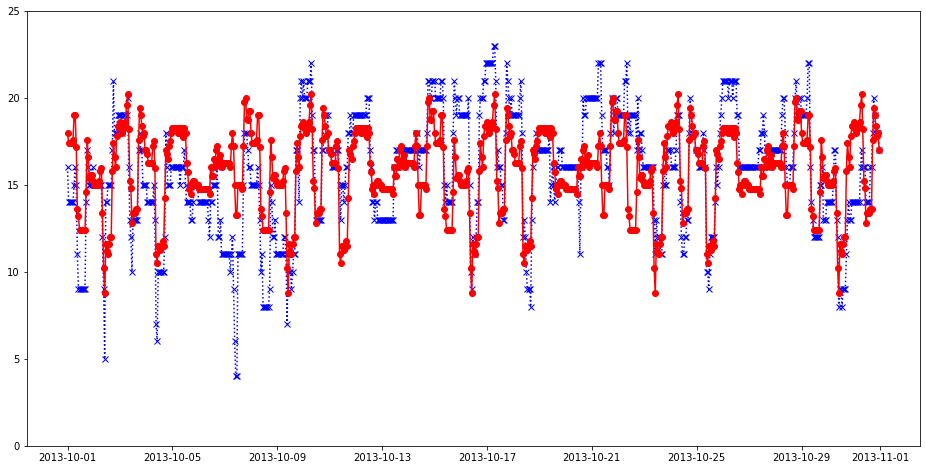

In [84]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [85]:
#trainデータのrmse
mean_squared_error(train_visualization_lightgbm['predict'].values, train_visualization_lightgbm['bikes_available'].values, squared=False)

2.4289863062572072

In [86]:
#2014/09/01以前をtrain、以後をtestに分割(testはpredict = 1のものに絞る)
test_visualization_lightgbm = status[status['date'] >= '2013-11-01']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['date'] < '2013-11-08']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['station_id'] == 0] 

test_visualization_lightgbm['predict'] = pred_lightgbm_test

test_visualization_lightgbm['date_hour'] = test_visualization_lightgbm['year'].astype(str) + '/' + test_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
test_visualization_lightgbm['date_hour'] = pd.to_datetime(test_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)
test_visualization_lightgbm

,id,year,month,day,hour,station_id,bikes_available,predict,date,city,...,CE_city_1,CE_city_2,CE_city_3,CE_city_4,CE_city_5,dock_count,installation_date,week_num,bikes_available_at0,date_hour
1464,1464,2013,11,1,0,0,17.0,17.001568,2013-11-01,city1,...,1,0,0,0,0,27,8/6/2013,4,17.0,2013-11-01 00:00:00
1465,1465,2013,11,1,1,0,16.0,16.746552,2013-11-01,city1,...,1,0,0,0,0,27,8/6/2013,4,17.0,2013-11-01 01:00:00
1466,1466,2013,11,1,2,0,16.0,16.254347,2013-11-01,city1,...,1,0,0,0,0,27,8/6/2013,4,17.0,2013-11-01 02:00:00
1467,1467,2013,11,1,3,0,16.0,16.245355,2013-11-01,city1,...,1,0,0,0,0,27,8/6/2013,4,17.0,2013-11-01 03:00:00
1468,1468,2013,11,1,4,0,16.0,16.253434,2013-11-01,city1,...,1,0,0,0,0,27,8/6/2013,4,17.0,2013-11-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,1627,2013,11,7,19,0,18.0,19.001619,2013-11-07,city1,...,1,0,0,0,0,27,8/6/2013,3,9.0,2013-11-07 19:00:00
1628,1628,2013,11,7,20,0,16.0,18.386227,2013-11-07,city1,...,1,0,0,0,0,27,8/6/2013,3,9.0,2013-11-07 20:00:00
1629,1629,2013,11,7,21,0,16.0,17.810000,2013-11-07,city1,...,1,0,0,0,0,27,8/6/2013,3,9.0,2013-11-07 21:00:00
1630,1630,2013,11,7,22,0,16.0,17.990484,2013-11-07,city1,...,1,0,0,0,0,27,8/6/2013,3,9.0,2013-11-07 22:00:00


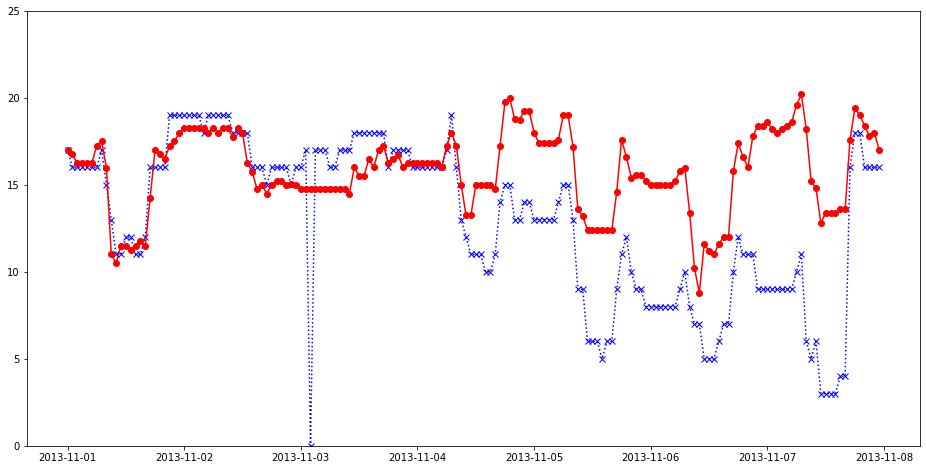

In [87]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [88]:
#testデータのrmse
mean_squared_error(test_visualization_lightgbm['predict'].values, test_visualization_lightgbm['bikes_available'].values, squared=False)

4.852889475854888

In [89]:
#ここからRandomForesr

In [90]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=15, random_state=0)
regr.fit(train_week_X, train_week_y)

RandomForestRegressor(max_depth=15, random_state=0)

In [91]:
#trainデータに対して予測
RF_train_predict = regr.predict(train_week_X)
RF_train_predict

array([18.08959921, 17.41453391, 17.50290476, 17.34321573, 17.28186508,
       17.66981349, 18.731579  , 18.80884921, 17.51076587, 13.51157937,
       13.26274206, 12.52335245, 12.08429437, 12.23589863, 12.30223016,
       12.23917208, 12.19466703, 14.64032468, 17.49800397, 16.47131854,
       15.43158333, 15.50417063, 15.55230159, 15.04374206, 15.22822619,
       14.90140837, 15.18187698, 15.08303968, 15.03287698, 15.5082381 ,
       15.80985462, 15.82996825, 13.38270238, 10.33900758,  8.72771861,
       11.45450902, 11.28237626, 11.02648016, 11.61240079, 11.95178896,
       11.97309524, 15.7203658 , 17.57642857, 16.5206039 , 16.05684951,
       17.97037266, 18.69867063, 18.49358333, 18.64952994, 18.15851984,
       18.06597619, 18.23079365, 18.61136905, 18.75903968, 19.5967619 ,
       20.10547511, 18.07982937, 15.17424928, 14.93219841, 12.79352165,
       13.30952922, 13.29388456, 13.40606746, 13.57438636, 13.56447944,
       17.59029978, 19.20066667, 19.07893101, 18.32591667, 17.71

In [92]:
train_visualization_lightgbm['RF_train_predict'] = RF_train_predict

In [93]:
#trainデータのrmse
mean_squared_error(train_visualization_lightgbm['RF_train_predict'].values, train_visualization_lightgbm['bikes_available'].values, squared=False)

2.4328717764081658

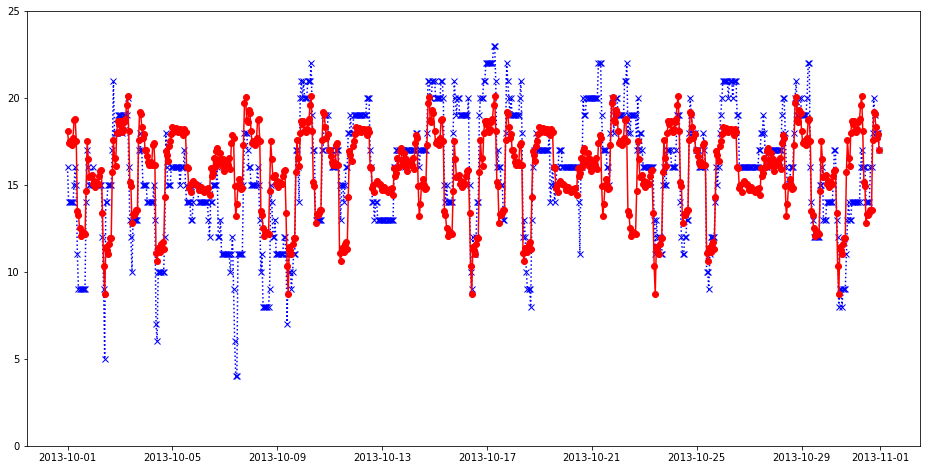

In [94]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['RF_train_predict'].values, color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [95]:
#testデータに対して予測
RF_test_predict = regr.predict(test_week_X)
RF_test_predict

array([17.01181746, 16.6438254 , 16.34249206, 16.12678571, 16.3246627 ,
       16.14127778, 17.29398413, 17.39561905, 16.14441667, 11.08788095,
       10.61021429, 11.36706349, 11.35617857, 11.16790476, 11.57627345,
       11.69844048, 11.3236746 , 14.31667857, 16.93101371, 16.70457143,
       16.36102778, 17.24405952, 17.52204762, 17.95088889, 18.30239574,
       18.04263095, 18.09560714, 18.27402922, 18.1122381 , 18.04280159,
       18.19189683, 18.21363564, 18.09908622, 18.17663889, 17.86682143,
       18.22051732, 18.05784921, 16.01442063, 15.96132792, 14.8208254 ,
       15.0074127 , 14.56597619, 15.12039683, 15.23822511, 15.13262302,
       15.07355159, 15.03981349, 14.93480952, 14.69635317, 14.80421429,
       14.85780556, 14.71559127, 14.7140873 , 14.60211905, 14.63150794,
       14.76934524, 14.77186905, 14.79635714, 14.42475397, 15.98064286,
       15.48419048, 15.68246032, 16.55395238, 16.03159307, 16.93498413,
       17.14482937, 16.42603968, 16.27324603, 16.81429762, 16.06

In [96]:
len(RF_test_predict)

168

In [97]:
test_visualization_lightgbm['RF_test_predict'] = RF_test_predict

#testデータのrmse
mean_squared_error(test_visualization_lightgbm['RF_test_predict'].values, test_visualization_lightgbm['bikes_available'].values, squared=False)

4.858824356911359

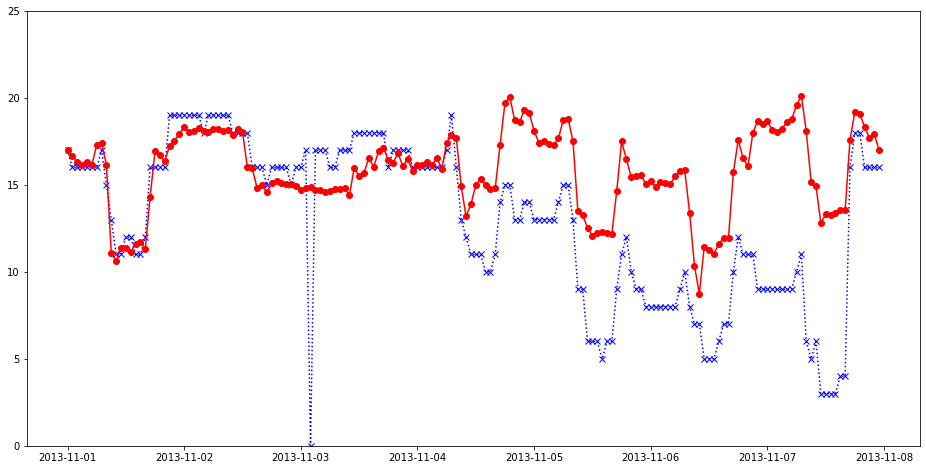

In [98]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['RF_test_predict'].values, color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [99]:
#ここからlstm

In [100]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import math
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_squared_error


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [101]:
from sklearn.model_selection import train_test_split
import category_encoders as ce

In [102]:
status = pd.read_csv('../../../status.csv')

In [103]:
status

,id,year,month,day,hour,station_id,bikes_available,predict
0,0,2013,9,1,0,0,11.0,0
1,1,2013,9,1,1,0,11.0,0
2,2,2013,9,1,2,0,11.0,0
3,3,2013,9,1,3,0,11.0,0
4,4,2013,9,1,4,0,11.0,0
...,...,...,...,...,...,...,...,...
1226395,1226395,2015,8,31,19,69,8.0,0
1226396,1226396,2015,8,31,20,69,8.0,0
1226397,1226397,2015,8,31,21,69,8.0,0
1226398,1226398,2015,8,31,22,69,8.0,0


In [104]:
#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str) + '/' + status['hour'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'], format='%Y/%m/%d/%H', infer_datetime_format=True)

#statusにstationのcityをマージ
status = pd.merge(status, station[['station_id', 'city']], how = 'left')

In [105]:
#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#dateから曜日情報を取得
status["weekday"] = status["date"].apply(get_weekday_jp)
status.head(10)

,id,year,month,day,hour,station_id,bikes_available,predict,date,city,weekday
0,0,2013,9,1,0,0,11.0,0,2013-09-01 00:00:00,city1,日曜日
1,1,2013,9,1,1,0,11.0,0,2013-09-01 01:00:00,city1,日曜日
2,2,2013,9,1,2,0,11.0,0,2013-09-01 02:00:00,city1,日曜日
3,3,2013,9,1,3,0,11.0,0,2013-09-01 03:00:00,city1,日曜日
4,4,2013,9,1,4,0,11.0,0,2013-09-01 04:00:00,city1,日曜日
5,5,2013,9,1,5,0,11.0,0,2013-09-01 05:00:00,city1,日曜日
6,6,2013,9,1,6,0,11.0,0,2013-09-01 06:00:00,city1,日曜日
7,7,2013,9,1,7,0,11.0,0,2013-09-01 07:00:00,city1,日曜日
8,8,2013,9,1,8,0,11.0,0,2013-09-01 08:00:00,city1,日曜日
9,9,2013,9,1,9,0,11.0,0,2013-09-01 09:00:00,city1,日曜日


In [106]:
main_df = status[['date','hour', 'station_id', 'bikes_available', 'weekday', 'predict']]
main_df

,date,hour,station_id,bikes_available,weekday,predict
0,2013-09-01 00:00:00,0,0,11.0,日曜日,0
1,2013-09-01 01:00:00,1,0,11.0,日曜日,0
2,2013-09-01 02:00:00,2,0,11.0,日曜日,0
3,2013-09-01 03:00:00,3,0,11.0,日曜日,0
4,2013-09-01 04:00:00,4,0,11.0,日曜日,0
...,...,...,...,...,...,...
1226395,2015-08-31 19:00:00,19,69,8.0,月曜日,0
1226396,2015-08-31 20:00:00,20,69,8.0,月曜日,0
1226397,2015-08-31 21:00:00,21,69,8.0,月曜日,0
1226398,2015-08-31 22:00:00,22,69,8.0,月曜日,0


In [107]:
#カテゴリ変数をダミー変数化
main_df = pd.get_dummies(main_df)
print(main_df.columns)
print(main_df.shape)

Index(['date', 'hour', 'station_id', 'bikes_available', 'predict',
       'weekday_土曜日', 'weekday_日曜日', 'weekday_月曜日', 'weekday_木曜日',
       'weekday_水曜日', 'weekday_火曜日', 'weekday_金曜日'],
      dtype='object')
(1226400, 12)


In [108]:
train = main_df[main_df['date'] >= '2013-09-30']
train = train[train['date'] < '2013-11-01']
train = train[train['station_id'] == 0] 
train

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
696,2013-09-30 00:00:00,0,0,18.0,0,0,0,1,0,0,0,0
697,2013-09-30 01:00:00,1,0,18.0,0,0,0,1,0,0,0,0
698,2013-09-30 02:00:00,2,0,17.0,0,0,0,1,0,0,0,0
699,2013-09-30 03:00:00,3,0,17.0,0,0,0,1,0,0,0,0
700,2013-09-30 04:00:00,4,0,17.0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2013-10-31 19:00:00,19,0,19.0,0,0,0,0,1,0,0,0
1460,2013-10-31 20:00:00,20,0,18.0,0,0,0,0,1,0,0,0
1461,2013-10-31 21:00:00,21,0,18.0,0,0,0,0,1,0,0,0
1462,2013-10-31 22:00:00,22,0,18.0,0,0,0,0,1,0,0,0


In [109]:
test = main_df[main_df['date'] >= '2013-10-31']
test = test[test['date'] < '2013-11-08']
test = test[test['station_id'] == 0] 
test

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
1440,2013-10-31 00:00:00,0,0,14.0,0,0,0,0,1,0,0,0
1441,2013-10-31 01:00:00,1,0,14.0,0,0,0,0,1,0,0,0
1442,2013-10-31 02:00:00,2,0,14.0,0,0,0,0,1,0,0,0
1443,2013-10-31 03:00:00,3,0,14.0,0,0,0,0,1,0,0,0
1444,2013-10-31 04:00:00,4,0,14.0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1627,2013-11-07 19:00:00,19,0,18.0,0,0,0,0,1,0,0,0
1628,2013-11-07 20:00:00,20,0,16.0,0,0,0,0,1,0,0,0
1629,2013-11-07 21:00:00,21,0,16.0,0,0,0,0,1,0,0,0
1630,2013-11-07 22:00:00,22,0,16.0,0,0,0,0,1,0,0,0


In [110]:
#predictは特徴量として必要ないため、削除
train = train.drop("predict",axis=1)
train

,date,hour,station_id,bikes_available,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
696,2013-09-30 00:00:00,0,0,18.0,0,0,1,0,0,0,0
697,2013-09-30 01:00:00,1,0,18.0,0,0,1,0,0,0,0
698,2013-09-30 02:00:00,2,0,17.0,0,0,1,0,0,0,0
699,2013-09-30 03:00:00,3,0,17.0,0,0,1,0,0,0,0
700,2013-09-30 04:00:00,4,0,17.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1459,2013-10-31 19:00:00,19,0,19.0,0,0,0,1,0,0,0
1460,2013-10-31 20:00:00,20,0,18.0,0,0,0,1,0,0,0
1461,2013-10-31 21:00:00,21,0,18.0,0,0,0,1,0,0,0
1462,2013-10-31 22:00:00,22,0,18.0,0,0,0,1,0,0,0


In [111]:
#今回LSTMモデルを使用するため、データを標準化
#特徴量を標準化するための変数
scaler = MinMaxScaler(feature_range=(0, 1))
#標準化された出力をもとにスケールに変換(inverse)するために必要な変数
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
train_df_scale = scaler.fit_transform(train.iloc[:,3:])
bikes_available_scale = scaler_for_inverse.fit_transform(train[["bikes_available"]])
print(train_df_scale.shape)

(768, 8)


In [112]:
length = len(train_df_scale)
train_size = int(length)
train = train_df_scale[0:train_size,:]
print(train.shape)

(768, 8)


In [113]:
def create_dataset(dataset):
    dataX = []
    dataY = np.array([])
    #1680で1つのデータセットであるため、余りの分は使わない
    
    max_len = len(dataset)
    for i in range(24,max_len,1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i-24:i, j]
            xset.append(a)
        temp_array = np.array(dataset[i:i+1,0])
        dataY = np.concatenate([dataY,temp_array])
        dataX.append(xset)
    dataY = dataY.reshape(-1,1)
    return np.array(dataX), dataY 

In [114]:
trainX, trainY = create_dataset(train)

In [115]:
#LSTMのモデルに入力用にデータの形を整形
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
#入力データと正解データの形を確認
print(trainX.shape)
print(trainY.shape)

(744, 8, 24)
(744, 1)


In [116]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1],24)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                15000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 15,051
Trainable params: 15,051
Non-trainable params: 0
_________________________________________________________________


In [117]:
hist = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
744/744 - 2s - loss: 0.0267
Epoch 2/20
744/744 - 1s - loss: 0.0147
Epoch 3/20
744/744 - 1s - loss: 0.0126
Epoch 4/20
744/744 - 1s - loss: 0.0095
Epoch 5/20
744/744 - 1s - loss: 0.0092
Epoch 6/20
744/744 - 1s - loss: 0.0081
Epoch 7/20
744/744 - 1s - loss: 0.0073
Epoch 8/20
744/744 - 1s - loss: 0.0069
Epoch 9/20
744/744 - 1s - loss: 0.0064
Epoch 10/20
744/744 - 1s - loss: 0.0064
Epoch 11/20
744/744 - 1s - loss: 0.0063
Epoch 12/20
744/744 - 1s - loss: 0.0058
Epoch 13/20
744/744 - 1s - loss: 0.0057
Epoch 14/20
744/744 - 1s - loss: 0.0057
Epoch 15/20
744/744 - 1s - loss: 0.0059
Epoch 16/20
744/744 - 1s - loss: 0.0051
Epoch 17/20
744/744 - 1s - loss: 0.0051
Epoch 18/20
744/744 - 1s - loss: 0.0047
Epoch 19/20
744/744 - 1s - loss: 0.0049
Epoch 20/20
744/744 - 1s - loss: 0.0048


In [118]:
#学習済みモデルで予測
train_predict = model.predict(trainX)
#test_predict = model.predict(testX)

#スケールをもとに戻す
train_predict = scaler_for_inverse.inverse_transform(train_predict)
trainY = scaler_for_inverse.inverse_transform(trainY)
#test_predict = scaler_for_inverse.inverse_transform(test_predict)
#testY = scaler_for_inverse.inverse_transform(testY)

#各ステーションのスコアの平均値を算出
train_score_list = []
#test_score_list = []

trainscore = math.sqrt(mean_squared_error(trainY[:,0], train_predict[:,0]))
train_score_list.append(trainscore)
#    testscore = math.sqrt(mean_squared_error(testY[:,i], test_predict[:,i]))
#    test_score_list.append(testscore)
    
print("trainのRMSE平均 : ",mean(train_score_list))
#print("testのRMSE平均 : ",mean(test_score_list))

trainのRMSE平均 :  1.1465138102598313


In [119]:
array = []
for i in train_predict:
    array.append(i[0])
array

[16.607487,
 15.713086,
 14.284469,
 14.281425,
 14.51237,
 14.955785,
 15.714994,
 15.984203,
 15.071835,
 12.097409,
 10.230801,
 9.621803,
 9.662316,
 9.433454,
 9.534299,
 9.381558,
 9.422789,
 11.887395,
 15.251544,
 16.117882,
 14.94298,
 14.5343685,
 14.54896,
 14.127222,
 14.760377,
 14.484931,
 14.414341,
 14.519986,
 14.547891,
 14.940026,
 15.639758,
 15.390273,
 12.947366,
 9.554947,
 9.0999565,
 9.581496,
 11.791904,
 12.835348,
 13.869642,
 14.184185,
 14.858149,
 17.737959,
 19.393715,
 18.941513,
 17.694271,
 18.043182,
 18.654486,
 18.543024,
 18.276045,
 19.290909,
 19.108356,
 18.745546,
 19.093521,
 19.154781,
 19.925018,
 19.778625,
 17.903961,
 13.801428,
 12.37378,
 12.819712,
 12.083474,
 13.152342,
 13.714917,
 13.626303,
 14.150534,
 16.836906,
 19.000364,
 18.397764,
 17.248867,
 17.15752,
 16.303202,
 15.560134,
 15.647679,
 14.879984,
 14.497692,
 14.28307,
 14.138425,
 14.590352,
 15.197958,
 14.9316845,
 12.855015,
 9.305075,
 8.016252,
 8.93561,
 10.0692

In [120]:
train_visualization_lightgbm['lstm_predict']= array

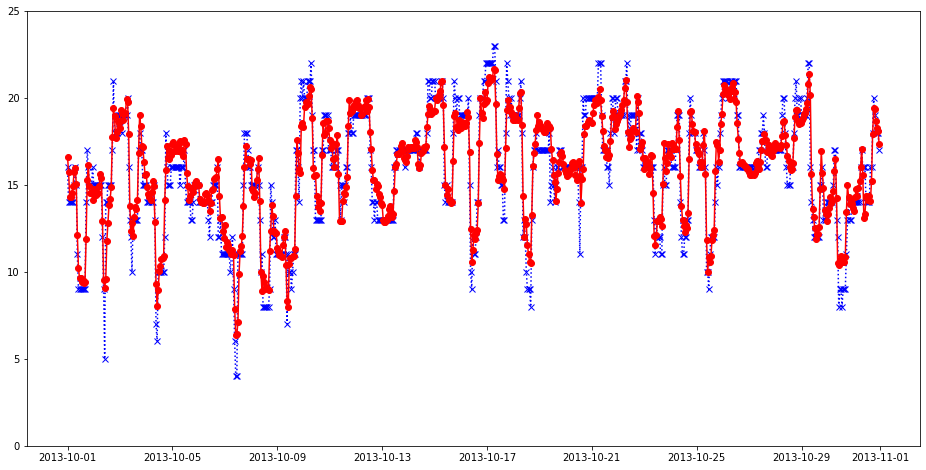

In [121]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['lstm_predict'].values, color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [122]:
#predictは特徴量として必要ないため、削除
test = test.drop("predict",axis=1)
test

,date,hour,station_id,bikes_available,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
1440,2013-10-31 00:00:00,0,0,14.0,0,0,0,1,0,0,0
1441,2013-10-31 01:00:00,1,0,14.0,0,0,0,1,0,0,0
1442,2013-10-31 02:00:00,2,0,14.0,0,0,0,1,0,0,0
1443,2013-10-31 03:00:00,3,0,14.0,0,0,0,1,0,0,0
1444,2013-10-31 04:00:00,4,0,14.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1627,2013-11-07 19:00:00,19,0,18.0,0,0,0,1,0,0,0
1628,2013-11-07 20:00:00,20,0,16.0,0,0,0,1,0,0,0
1629,2013-11-07 21:00:00,21,0,16.0,0,0,0,1,0,0,0
1630,2013-11-07 22:00:00,22,0,16.0,0,0,0,1,0,0,0


In [123]:
#今回LSTMモデルを使用するため、データを標準化
#特徴量を標準化するための変数
scaler = MinMaxScaler(feature_range=(0, 1))
#標準化された出力をもとにスケールに変換(inverse)するために必要な変数
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
test_df_scale = scaler.fit_transform(test.iloc[:,3:])
bikes_available_scale = scaler_for_inverse.fit_transform(test[["bikes_available"]])
print(test_df_scale.shape)

(192, 8)


In [124]:
length = len(test_df_scale)
test = test_df_scale[0:length,:]
print(test.shape)

(192, 8)


In [125]:
testX, testY = create_dataset(test)

In [126]:
#LSTMのモデルに入力用にデータの形を整形
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))
#入力データと正解データの形を確認
print(testX.shape)
print(testY.shape)

(168, 8, 24)
(168, 1)


In [127]:
#学習済みモデルで予測
#train_predict = model.predict(trainX)
test_predict = model.predict(testX)

#スケールをもとに戻す
#train_predict = scaler_for_inverse.inverse_transform(train_predict)
#trainY = scaler_for_inverse.inverse_transform(trainY)
test_predict = scaler_for_inverse.inverse_transform(test_predict)
testY = scaler_for_inverse.inverse_transform(testY)

#各ステーションのスコアの平均値を算出
#train_score_list = []
test_score_list = []

#trainscore = math.sqrt(mean_squared_error(trainY[:,0], train_predict[:,0]))
#train_score_list.append(trainscore)
testscore = math.sqrt(mean_squared_error(testY[:,0], test_predict[:,0]))
test_score_list.append(testscore)
    
#print("trainのRMSE平均 : ",mean(train_score_list))
print("testのRMSE平均 : ",mean(test_score_list))

testのRMSE平均 :  2.0265272324312873


In [128]:
array_pred = []
for i in test_predict:
    array_pred.append(i[0])
array_pred

[15.74977,
 16.501974,
 16.194618,
 15.746344,
 15.397158,
 15.7922125,
 16.55823,
 16.372877,
 14.697734,
 11.125736,
 10.924099,
 11.043213,
 10.985729,
 11.748229,
 12.472686,
 11.934031,
 11.840829,
 14.963102,
 17.355618,
 16.798664,
 16.367268,
 16.922869,
 18.269794,
 18.312355,
 18.708574,
 18.362566,
 18.170639,
 18.038578,
 17.992502,
 17.363838,
 17.50017,
 17.820456,
 18.036106,
 18.533075,
 17.791822,
 17.659174,
 16.953371,
 15.348487,
 15.015255,
 13.821548,
 14.156591,
 14.568192,
 14.426379,
 14.592062,
 14.660129,
 14.5174885,
 14.525007,
 13.974639,
 13.993231,
 14.401781,
 14.852715,
 7.8425646,
 12.573852,
 14.392299,
 15.022531,
 15.07332,
 15.025338,
 14.72095,
 15.398695,
 14.826992,
 15.329837,
 15.141882,
 15.586133,
 15.755798,
 15.934039,
 16.60682,
 16.488703,
 15.404548,
 15.896282,
 15.055494,
 15.616501,
 15.831373,
 15.525909,
 15.3266535,
 15.004782,
 16.055824,
 15.9250145,
 15.861878,
 16.219826,
 16.545115,
 16.591423,
 14.853893,
 13.435823,
 12.93

In [129]:
test_visualization_lightgbm['lstm_predict']= array_pred

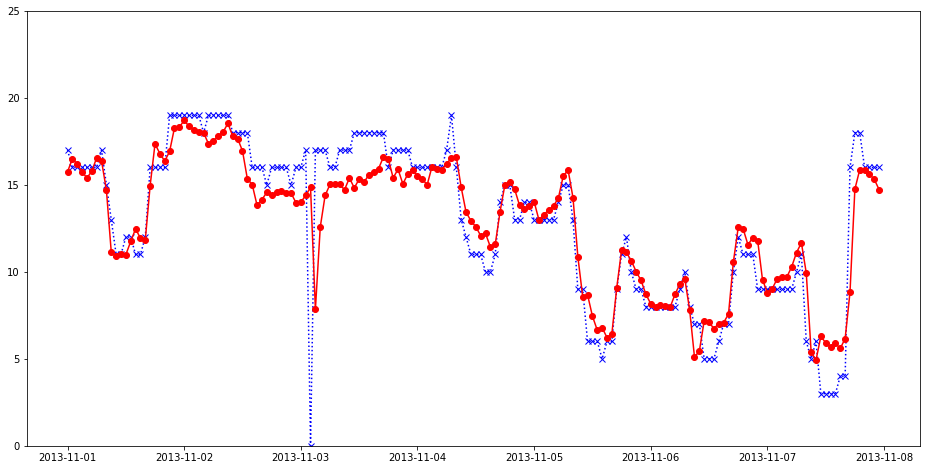

In [130]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lstm_predict'].values, color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [131]:
#最後に4モデルの比較

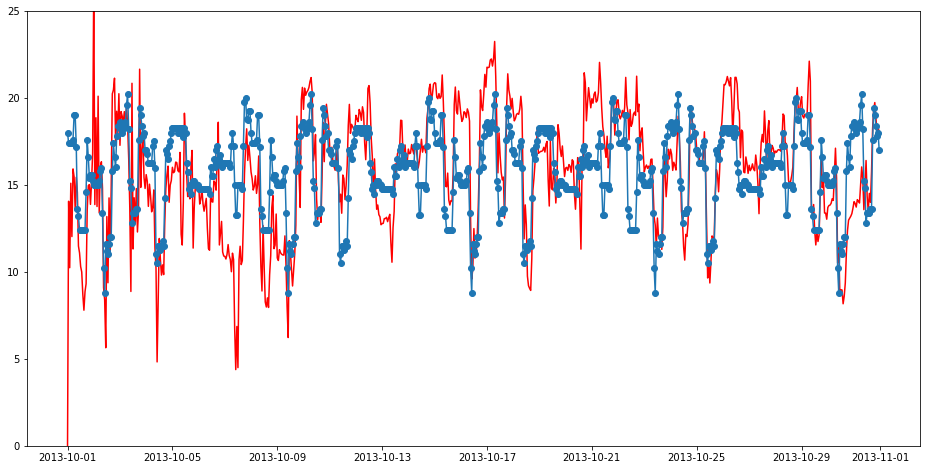

In [132]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)

#plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')

plt.plot(result_sarima_1.fittedvalues, color='red')

plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['predict'], marker = 'o', linestyle = '-', label = 'answer')

#plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['RF_train_predict'].values)

#plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['lstm_predict'].values)

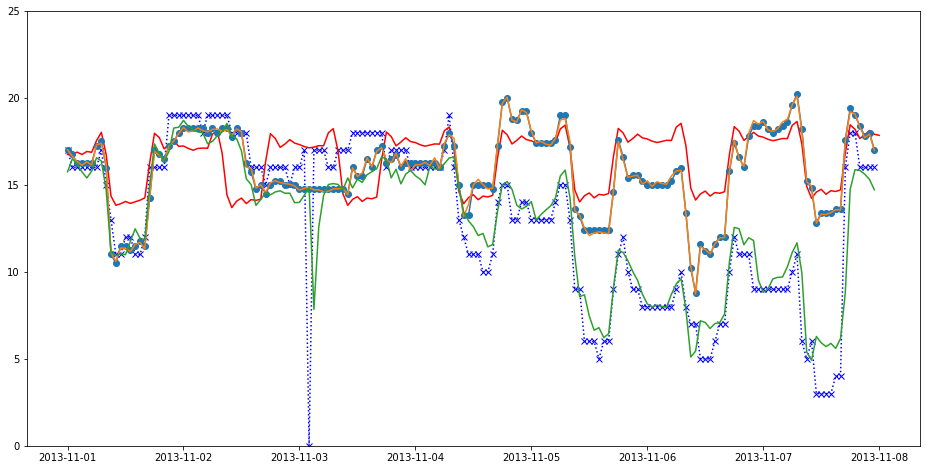

In [133]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)

plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')

plt.plot(predict_sarima_1, color='red')

plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], marker = 'o', linestyle = '-', label = 'answer')

plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['RF_test_predict'].values)

plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lstm_predict'].values)

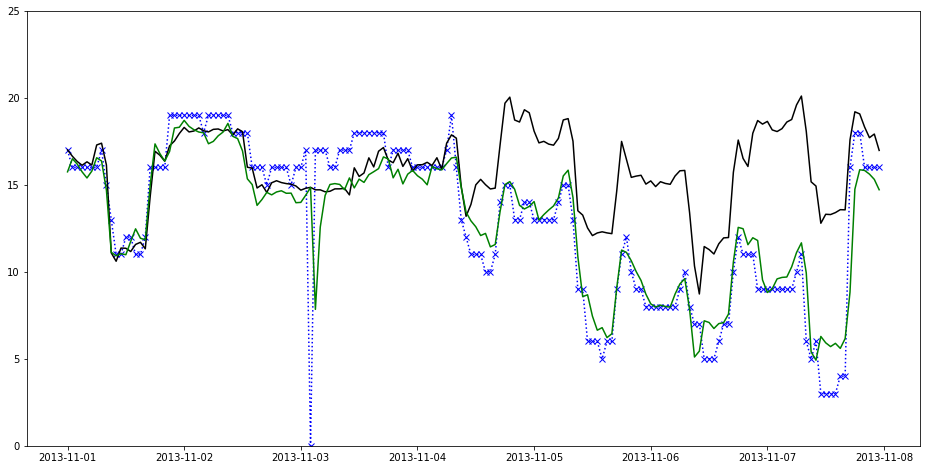

In [134]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)

plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')

#plt.plot(predict_sarima_1, color='red')

#plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], marker = 'o', linestyle = '-', label = 'answer')

plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['RF_test_predict'].values, color = 'black')

plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lstm_predict'].values, color = 'green')

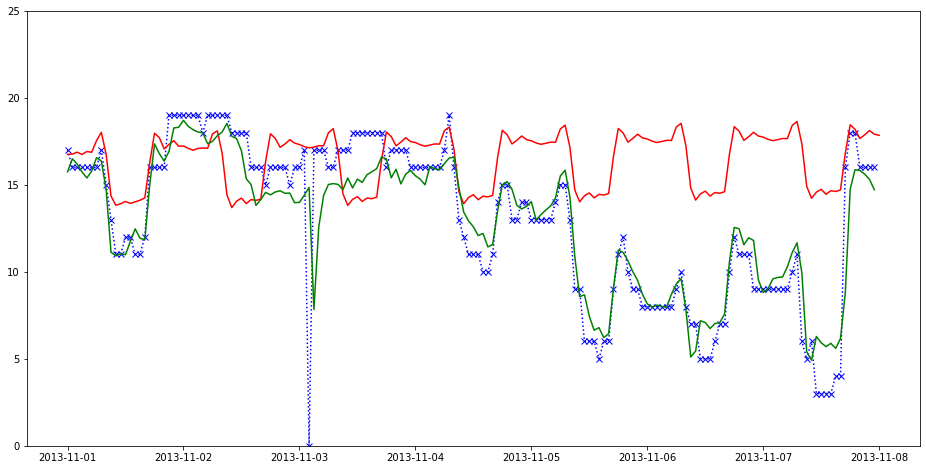

In [135]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)

plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')

plt.plot(predict_sarima_1, color='red')

#plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], marker = 'o', linestyle = '-', label = 'answer')

#plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['RF_test_predict'].values, color = 'black')

plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lstm_predict'].values, color = 'green')

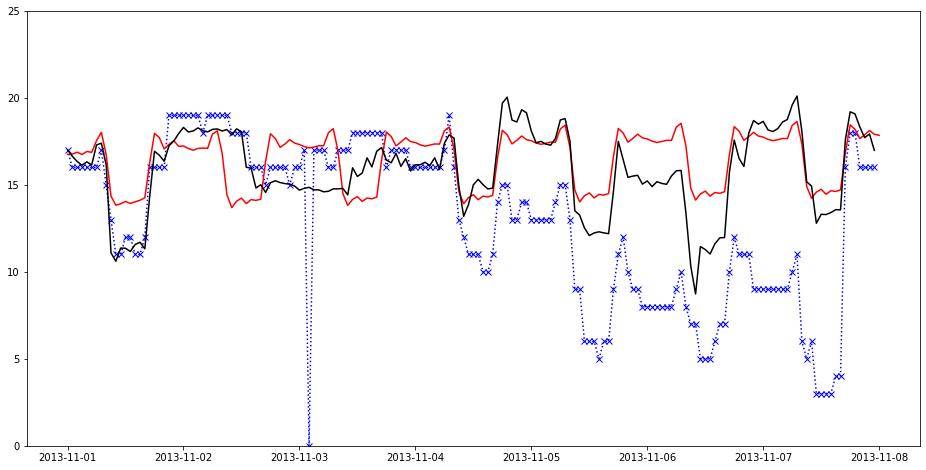

In [136]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)

plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')

plt.plot(predict_sarima_1, color='red')

#plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], marker = 'o', linestyle = '-', label = 'answer')

plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['RF_test_predict'].values, color = 'black')

#plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lstm_predict'].values, color = 'green')